In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords

In [ ]:
pd.options.display.max_colwidth = 250


In [ ]:
!pip install --upgrade transformers==4.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 6.9 MB/s 
     |████████████████████████████████| 880 kB 44.4 MB/s 
     |████████████████████████████████| 3.3 MB 40.2 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 596 kB 68.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=68905086d4557c809f3b66c980f3004e2a275b704eab6d77e6bd0c19925cdb2c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from matplotlib.ticker import StrMethodFormatter

In [ ]:
print(transformers.__version__)


4.10.1


In [ ]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [ ]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
!pip install torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
#import torch

bert = torch.load("/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/bertmodel.pth",map_location=torch.device('cpu'))
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/weights_only.pth')

In [ ]:
model_new = BERT()
model_new.to(device)

model_new.load_state_dict(torch.load('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/weights_only.pth'))

model_new

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
def test():
    bert.eval()
    bert_outputs = []

    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

In [ ]:
for chapter in range(1, 19):

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/' + str(chapter) + '.csv')

  new_df['Tweet'] = verses_df['slokas(no number)']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }   

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test()

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['Optimistic'] = "None"
  new_df['Thankful'] = "None"
  new_df['Empathetic'] = "None"
  new_df['Pessimistic'] = "None"
  new_df['Anxious'] = "None"
  new_df['Sad'] = "None"
  new_df['Annoyed'] = "None"
  new_df['Denial'] = "None"
  new_df['Official report'] = "None"
  new_df['Surprise'] = "None"
  new_df['Joking'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['Optimistic'].iloc[i] = test_outputs[i][0]
    new_df['Thankful'].iloc[i] = test_outputs[i][1]
    new_df['Empathetic'].iloc[i] = test_outputs[i][2]
    new_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    new_df['Anxious'].iloc[i] = test_outputs[i][4]
    new_df['Sad'].iloc[i] = test_outputs[i][5]
    new_df['Annoyed'].iloc[i] = test_outputs[i][6]
    new_df['Denial'].iloc[i] = test_outputs[i][7]
    new_df['Official report'].iloc[i] = test_outputs[i][8]
    new_df['Surprise'].iloc[i] = test_outputs[i][9]
    new_df['Joking'].iloc[i] = test_outputs[i][10]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: ignored

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

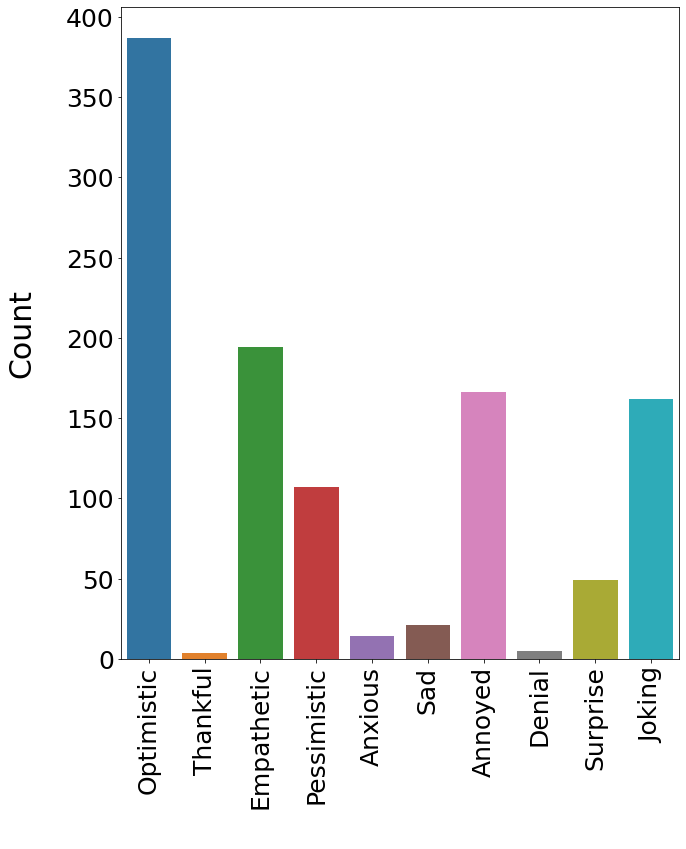

In [ ]:
total_df = pd.DataFrame()

for chapter in range(1,19):
  df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
  df = df.apply(pd.Series.value_counts)

  df['Optimistic'] = df['Optimistic'].fillna(0)
  df['Thankful'] = df['Thankful'].fillna(0)
  df['Empathetic'] = df['Empathetic'].fillna(0)
  df['Pessimistic'] = df['Pessimistic'].fillna(0)
  df['Anxious'] = df['Anxious'].fillna(0)
  df['Sad'] = df['Sad'].fillna(0)
  df['Annoyed'] = df['Annoyed'].fillna(0)
  df['Denial'] = df['Denial'].fillna(0)
  #df['Official report'] = df['Official report'].fillna(0)
  df['Surprise'] = df['Surprise'].fillna(0)
  df['Joking'] = df['Joking'].fillna(0)

  df = df.iloc[1]

  df = pd.DataFrame(df)

  df.columns = [ 'Count']

  total_df = total_df.append(df)

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index":"Sentiment"})

new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"], 
                       "Count":[0,0,0,0,0,0,0,0,0,0,]})

for ii in range(0, 10):
  for jj in range(0, 18):
    new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*10+ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)


sns.barplot(x = new_df.Sentiment, y = new_df.Count, ax = ax, palette = sns.color_palette("tab10"))

plt.xticks(rotation=90)

plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
# plt.title('All Chapters', fontsize = 25,  pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)

In [ ]:
def all_chapter_dataframe(path):
  total_df = pd.DataFrame()

  for chapter in range(1,19):
    df = pd.read_csv(path + str(chapter))

    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    total_df = total_df.append(df)
  
  total_df = total_df.reset_index()
  total_df = total_df.rename(columns={"index":"Sentiment"})

  new_df = pd.DataFrame({"Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"], 
                       "Count":[0,0,0,0,0,0,0,0,0,0,]})

  for ii in range(0, 10):
    for jj in range(0, 18):
      new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*10+ii, 'Count']).astype(int)

  return new_df

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

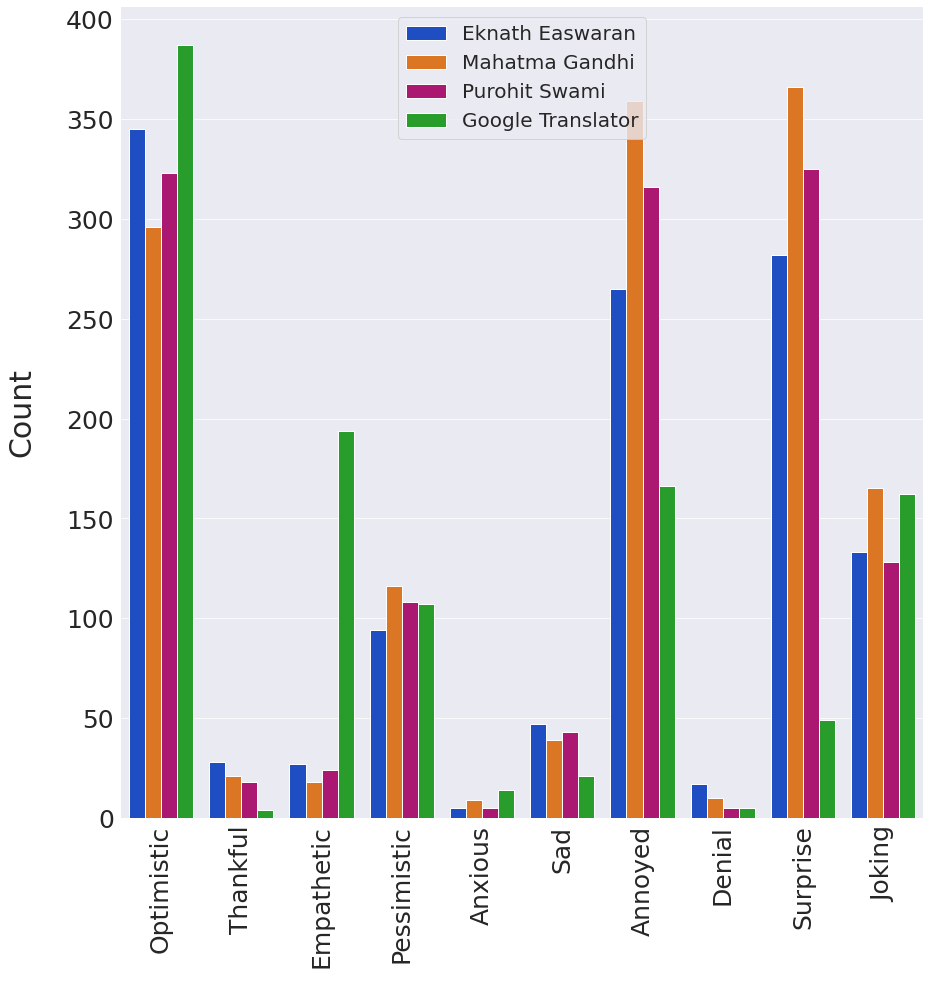

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter ')
google_translator = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ')
df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count'], google_translator['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami', 'Google Translator']

df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

# sns.color_palette("tab10")

# sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=10, palette = "tab10")

colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette = myPalette, legend=False)

g.despine(left=True)

plt.legend(loc='upper center',prop={"size":20})

plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)

In [ ]:
def chapter_wise_dataframe(path, chapter):
  
    df = pd.read_csv(path + str(chapter))

    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    #df['Official report'] = df['Official report'].fillna(0)
    df['Surprise'] = df['Surprise'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    return df

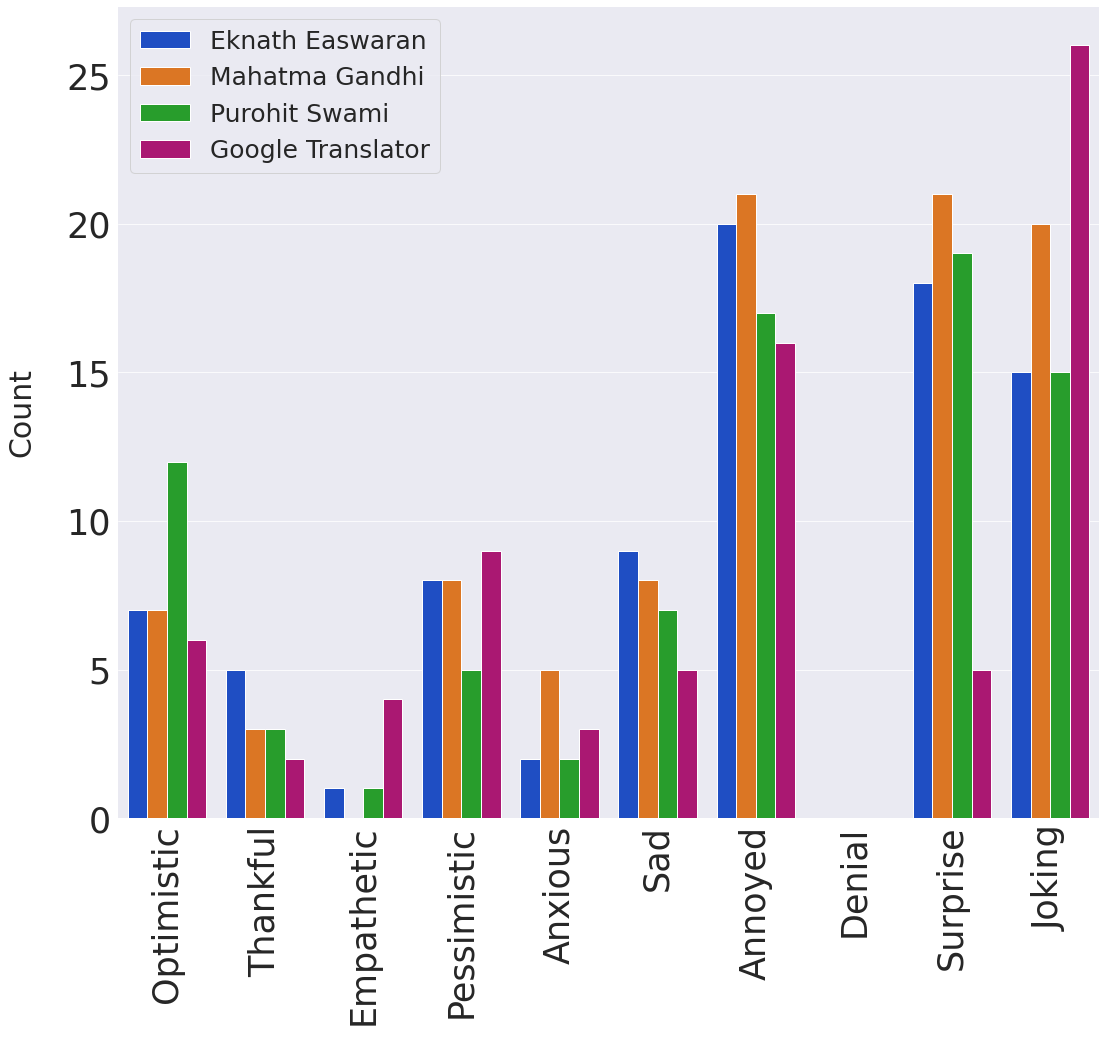

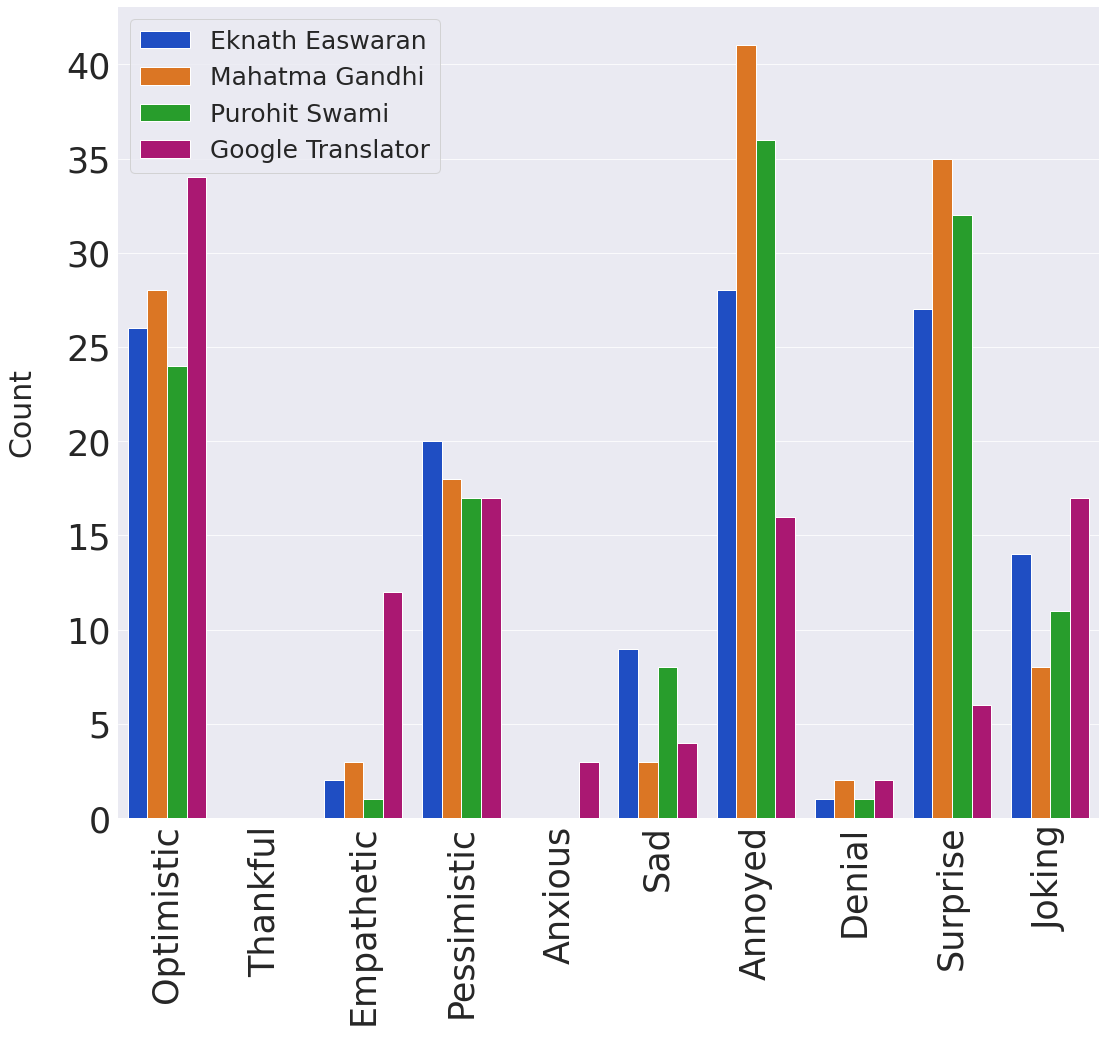

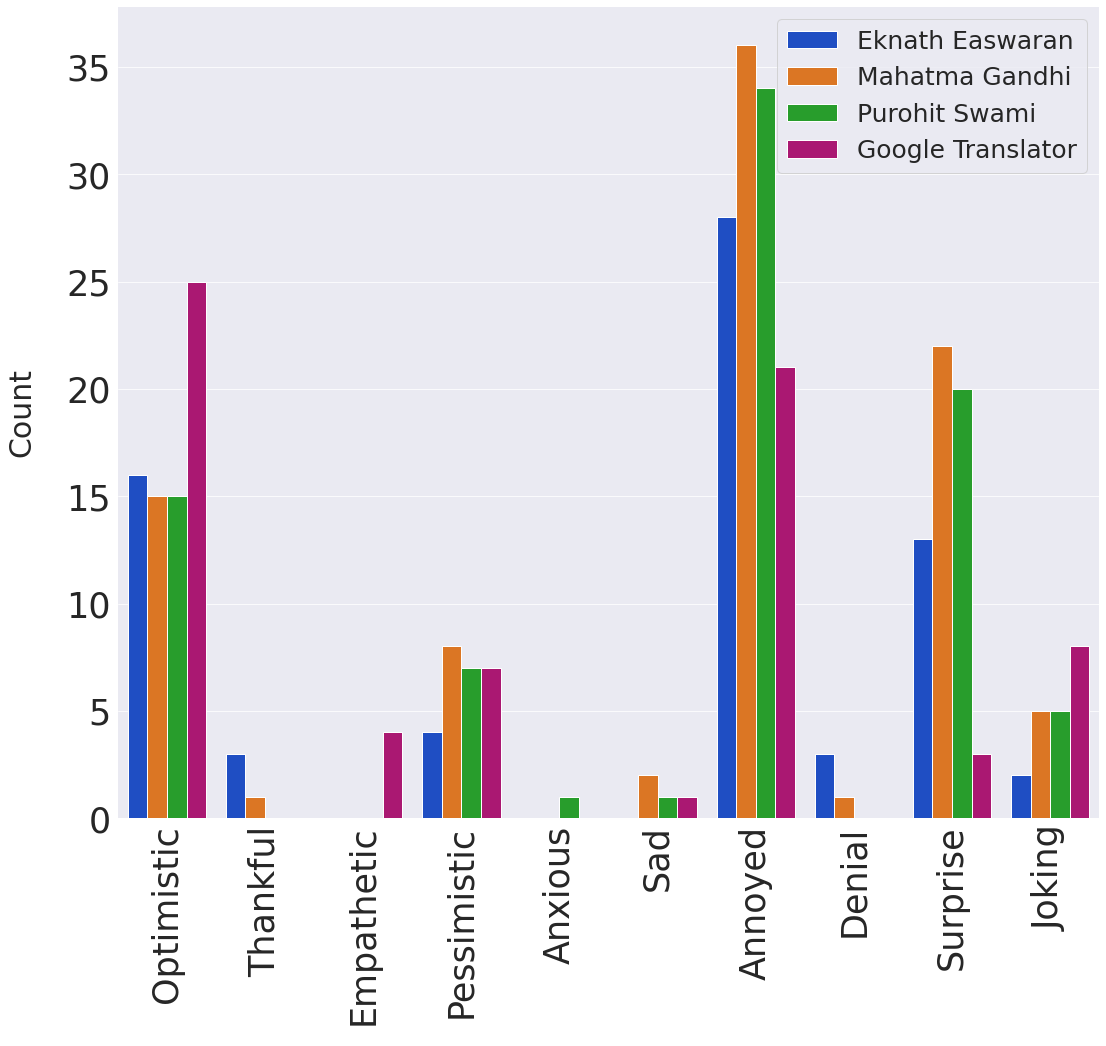

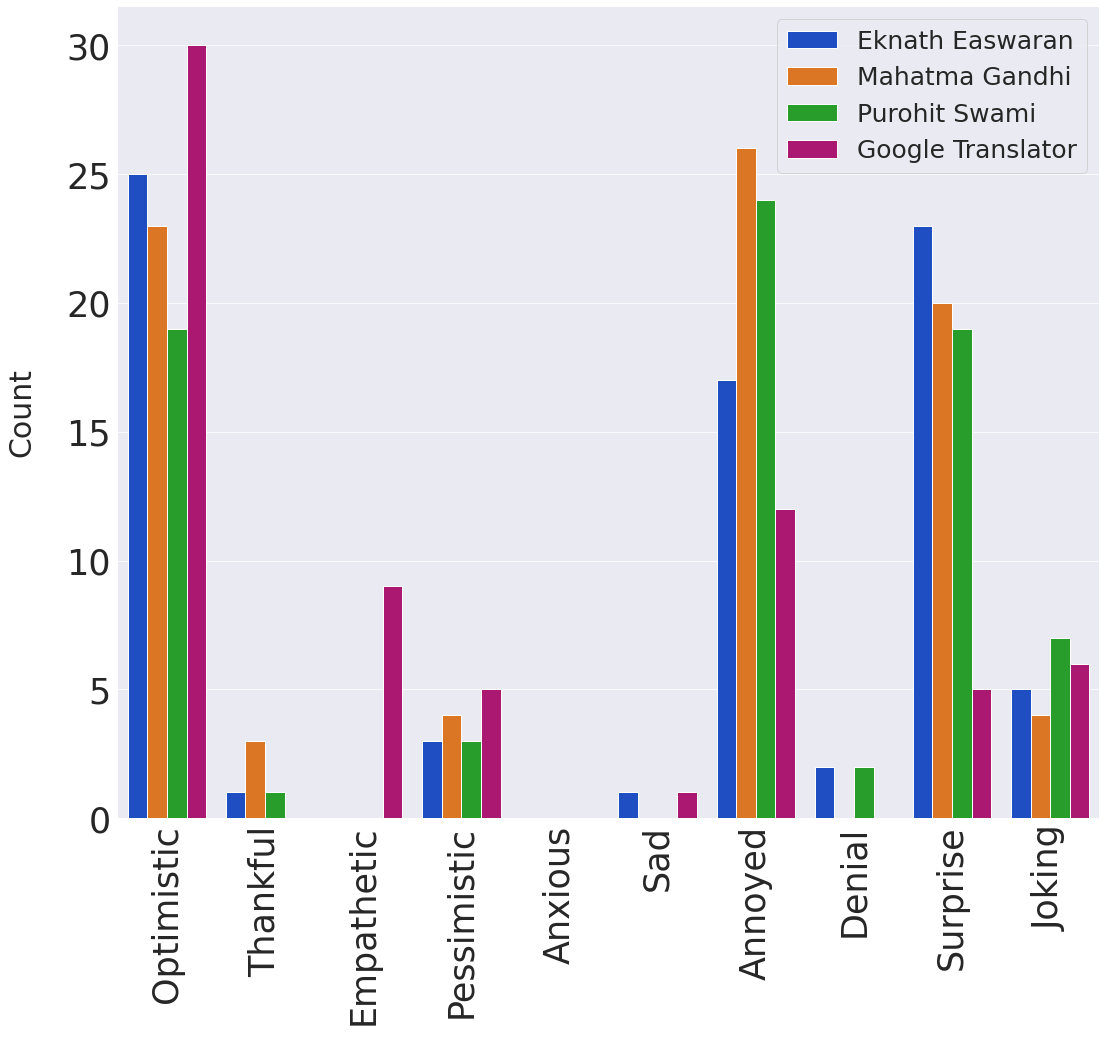

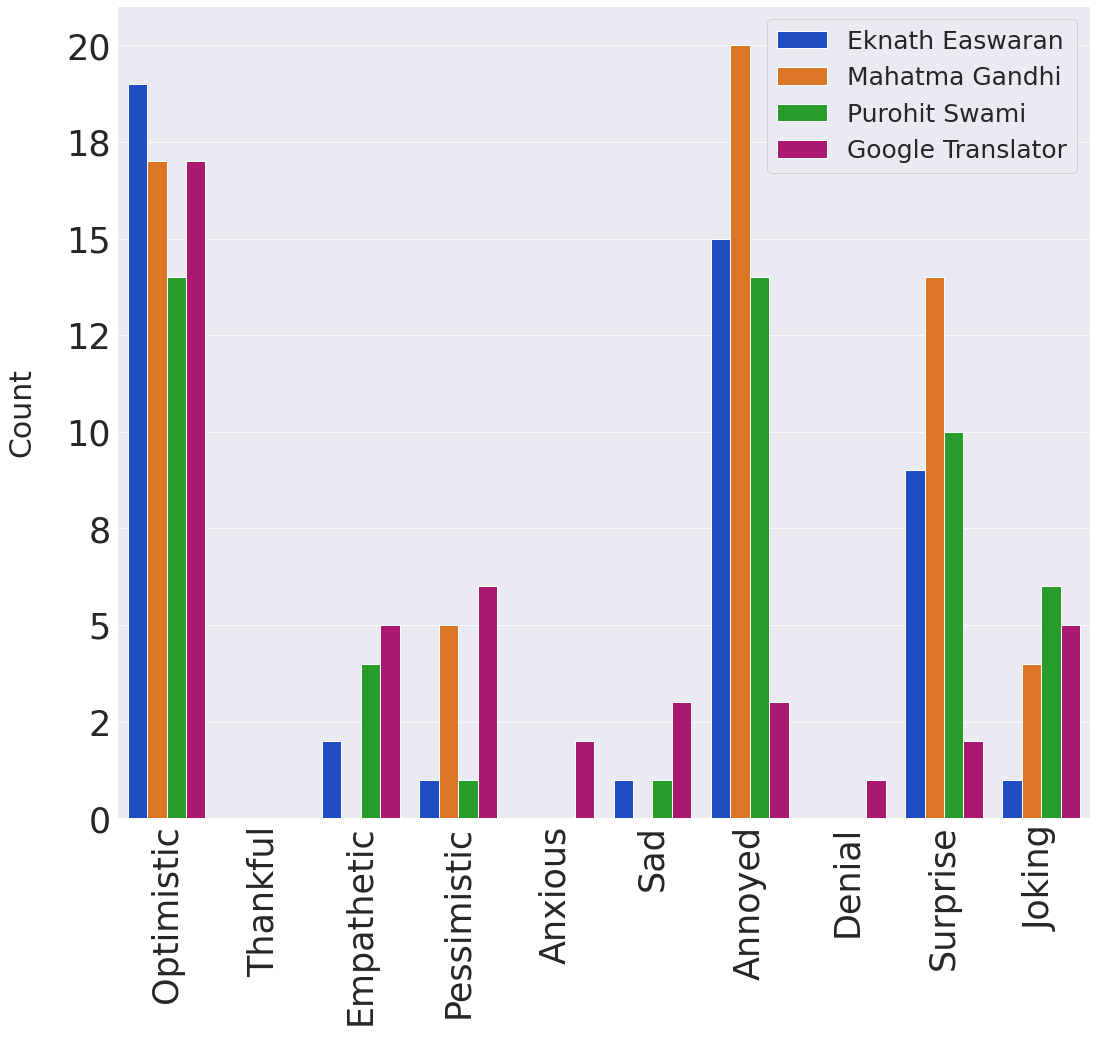

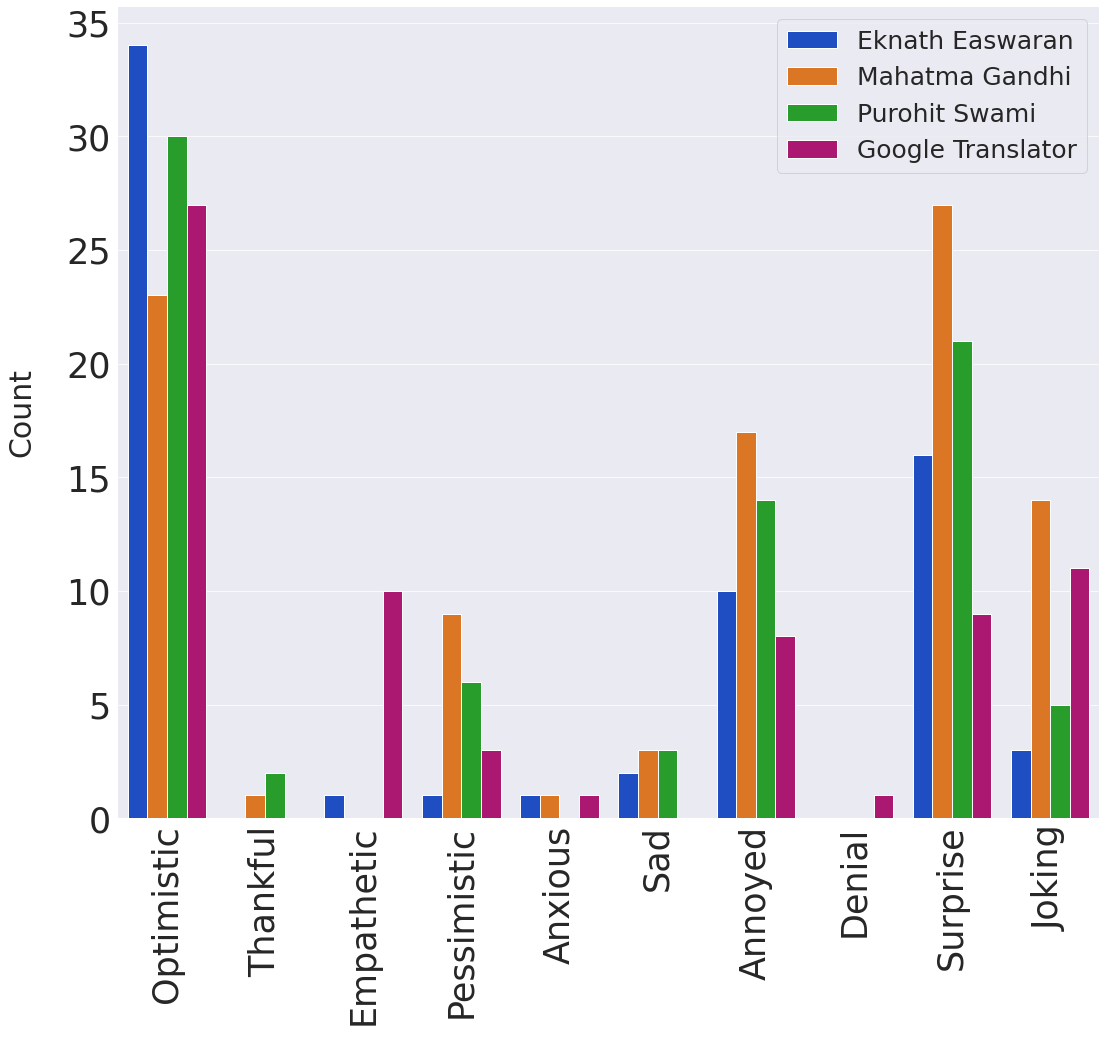

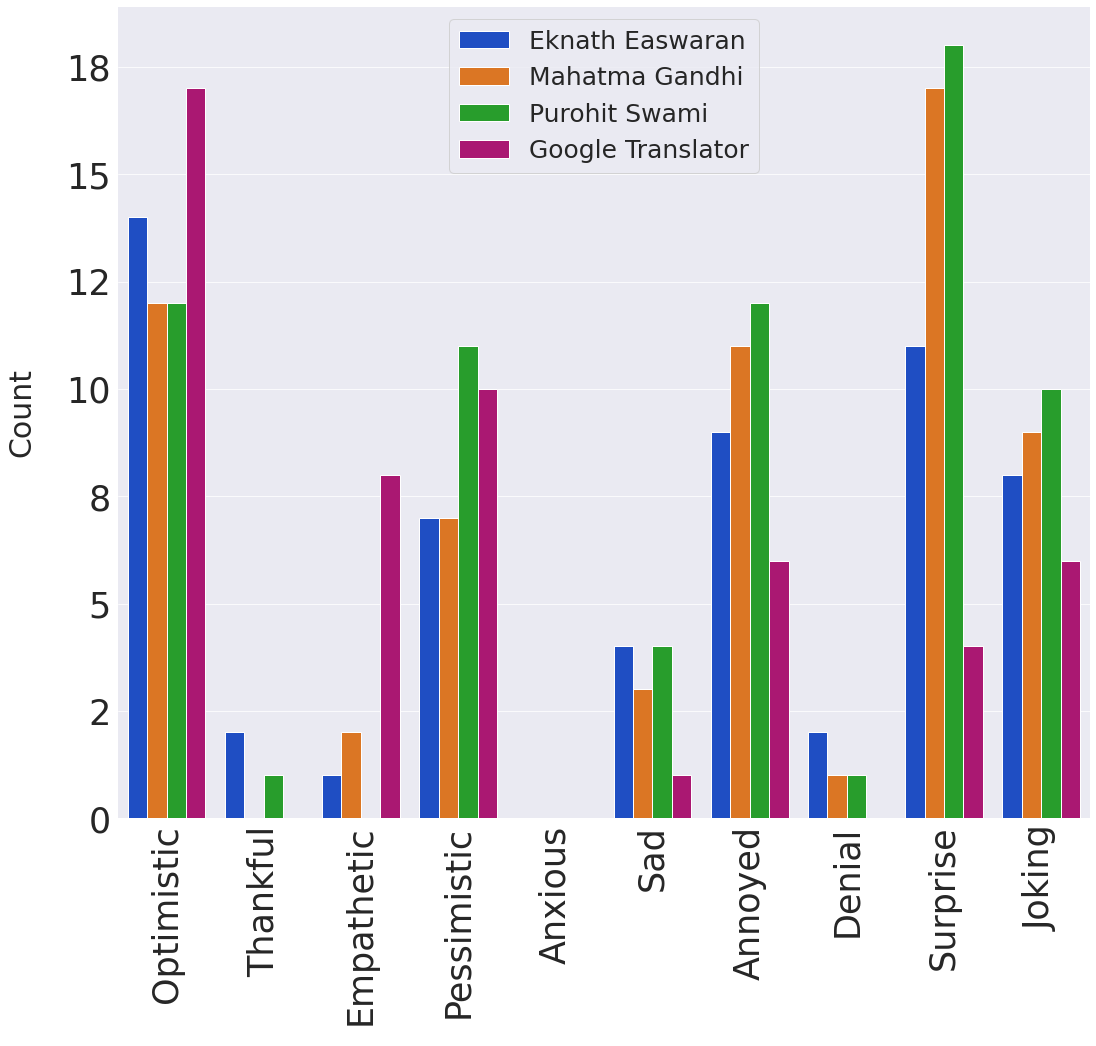

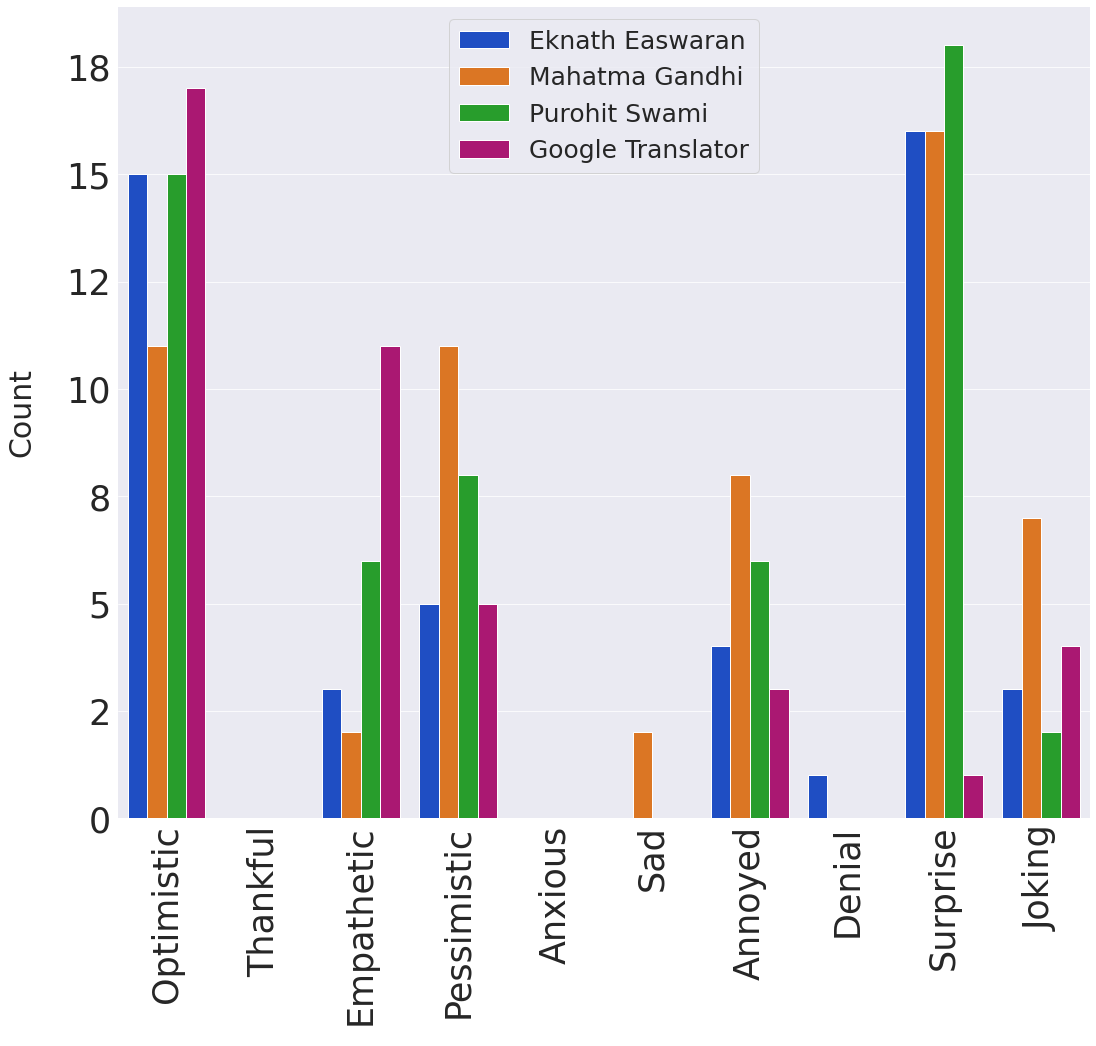

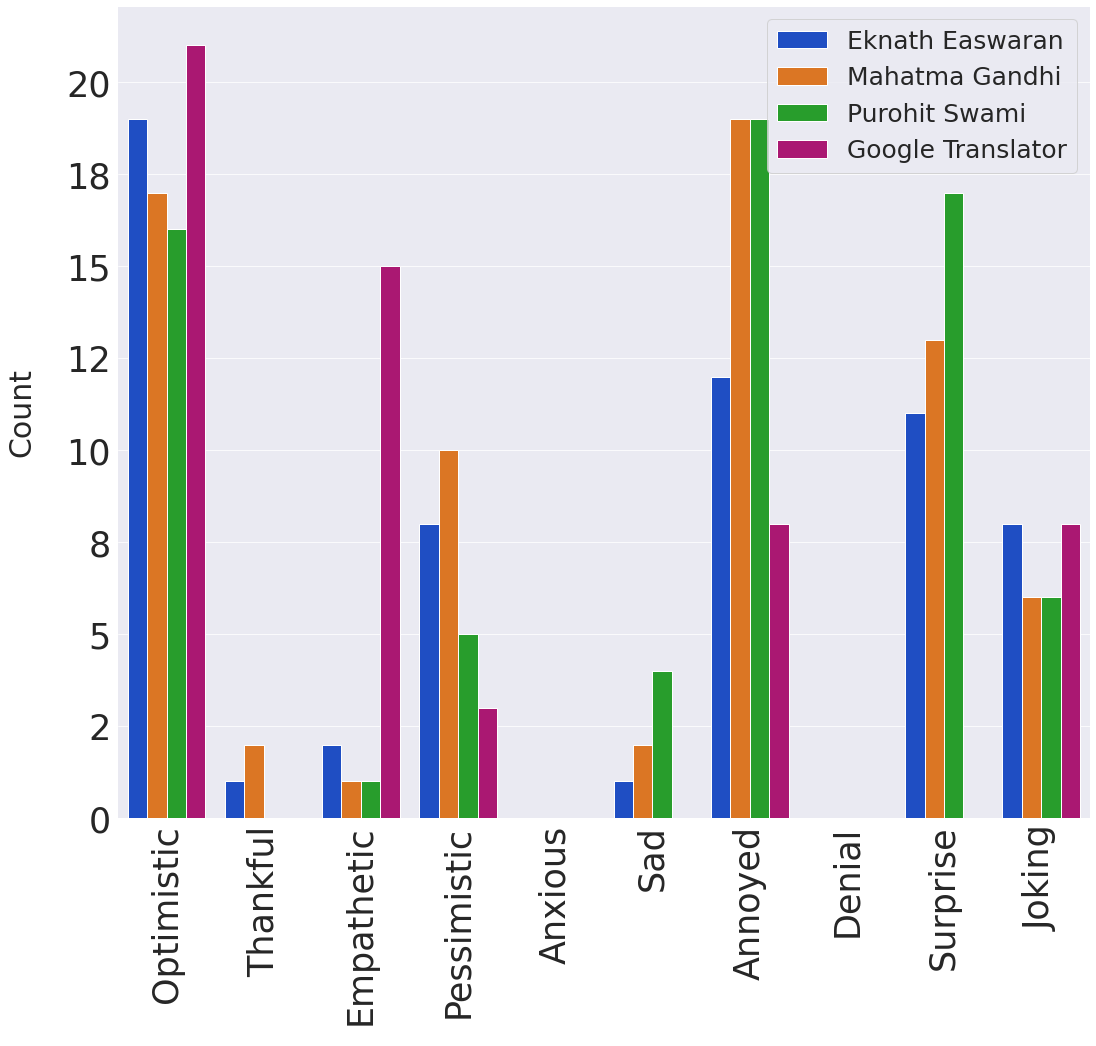

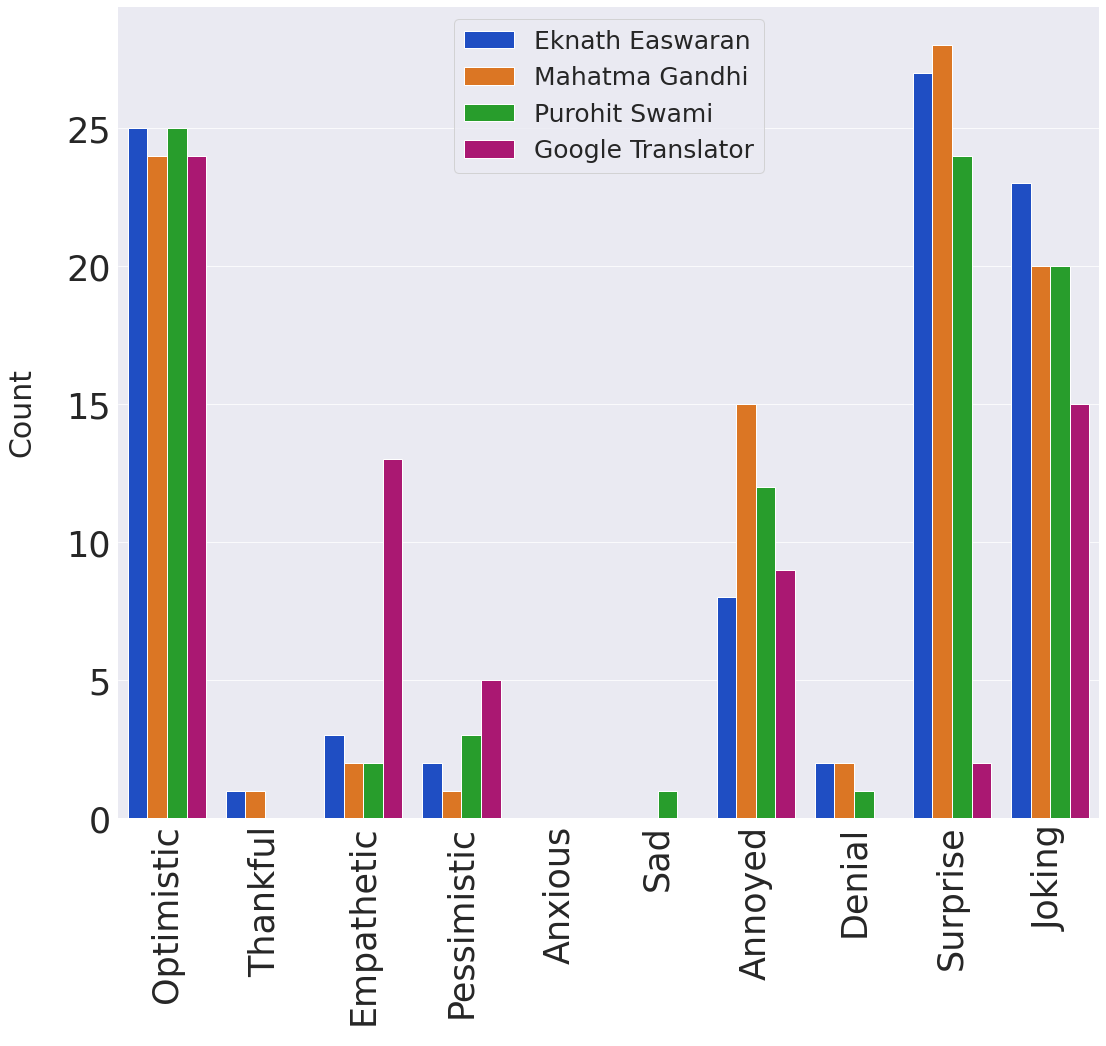

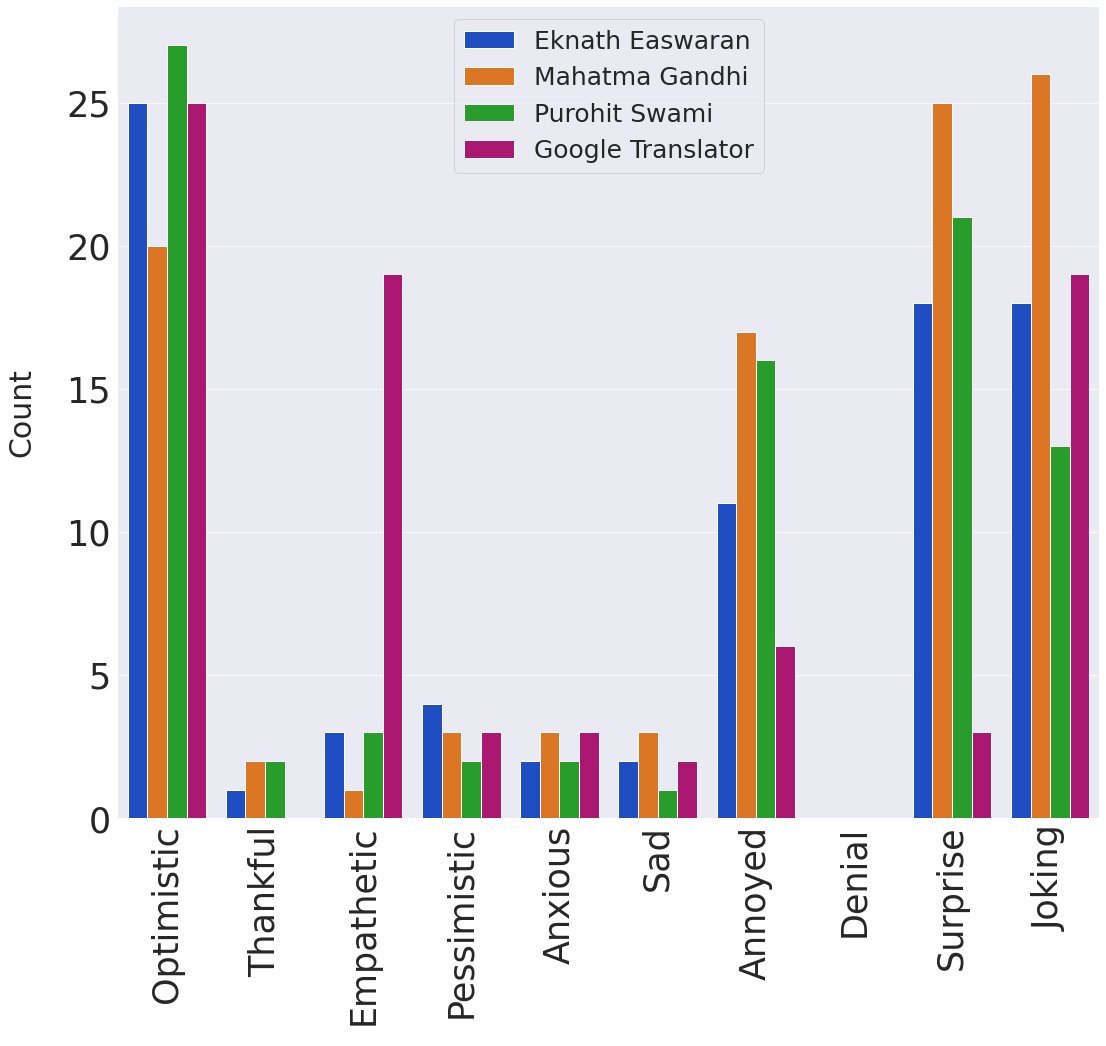

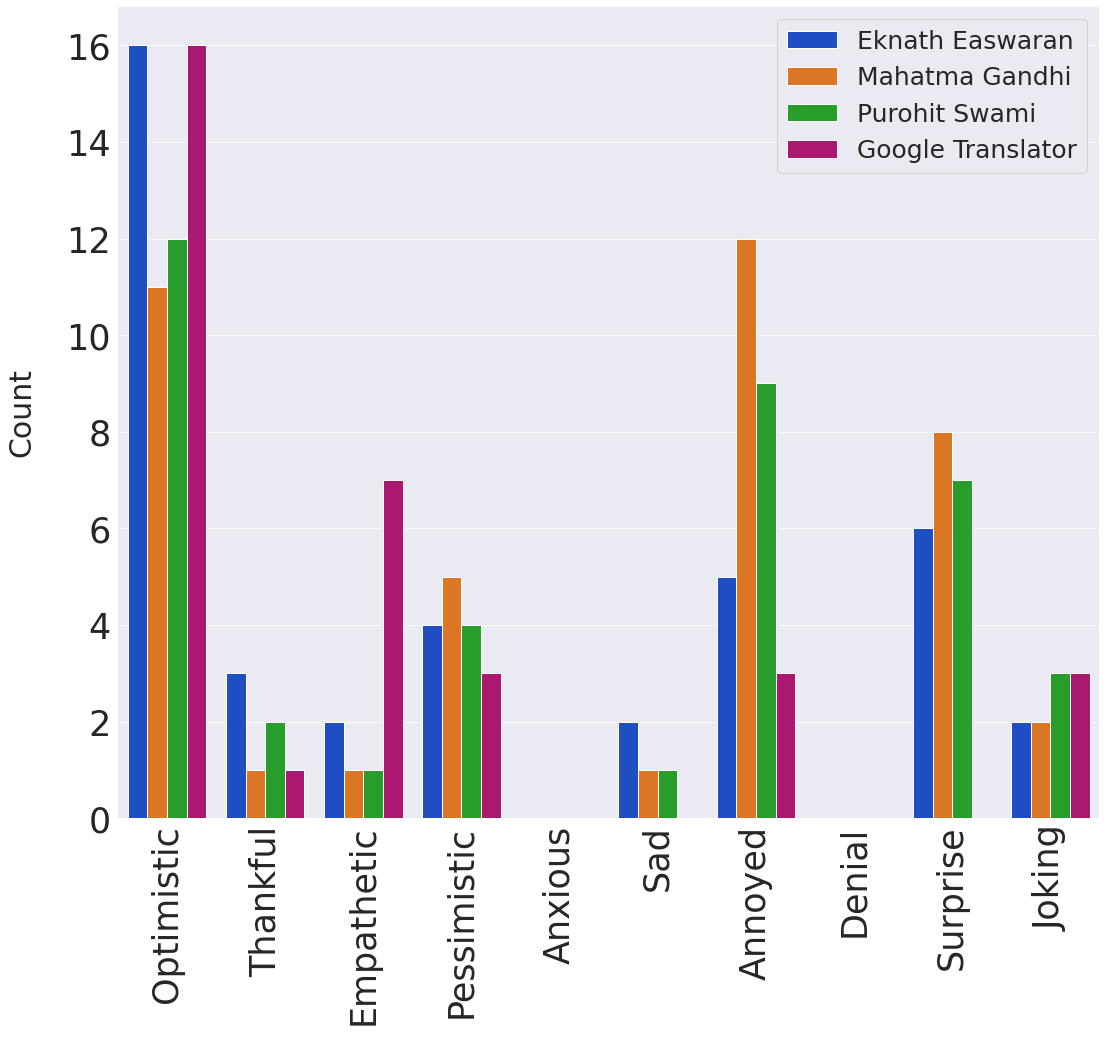

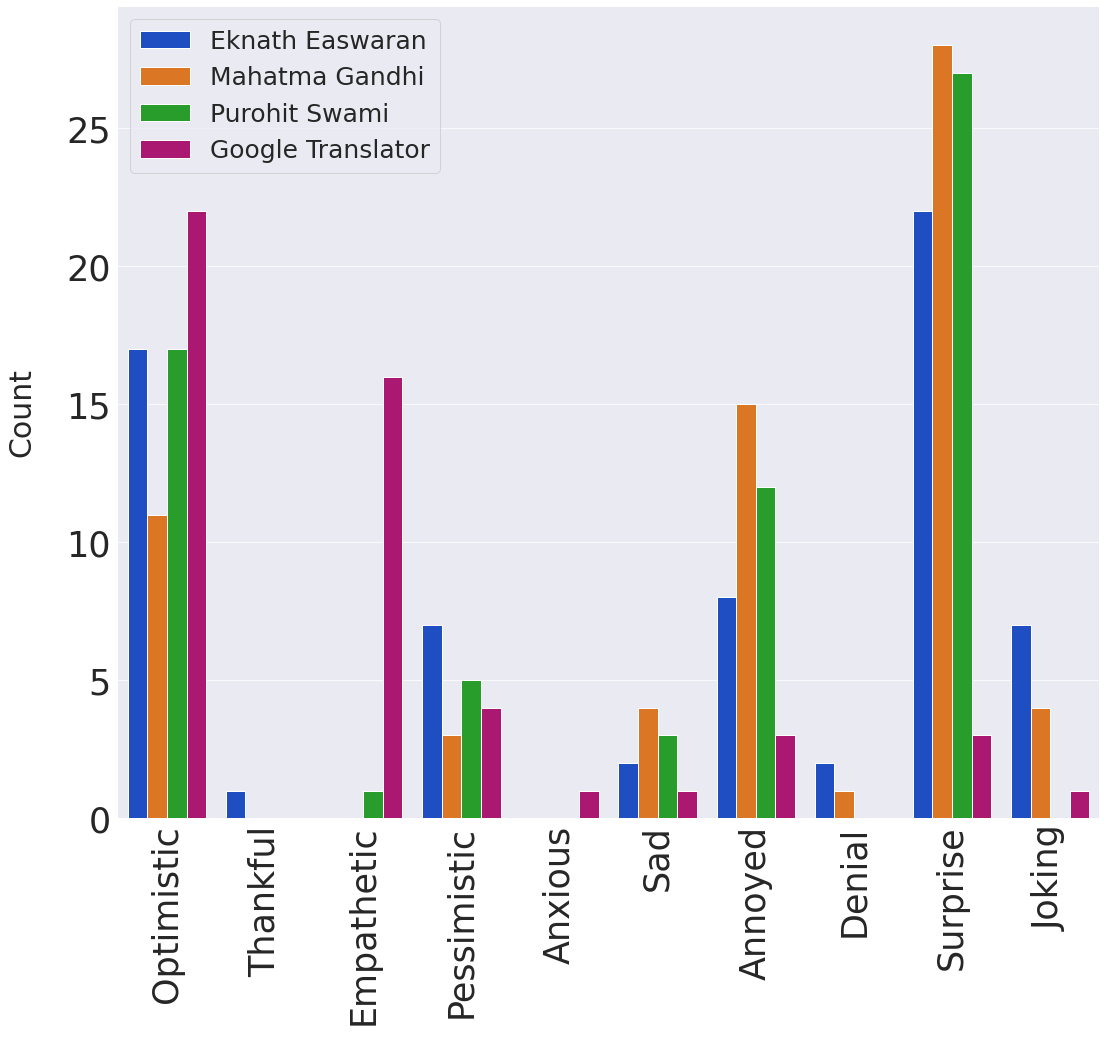

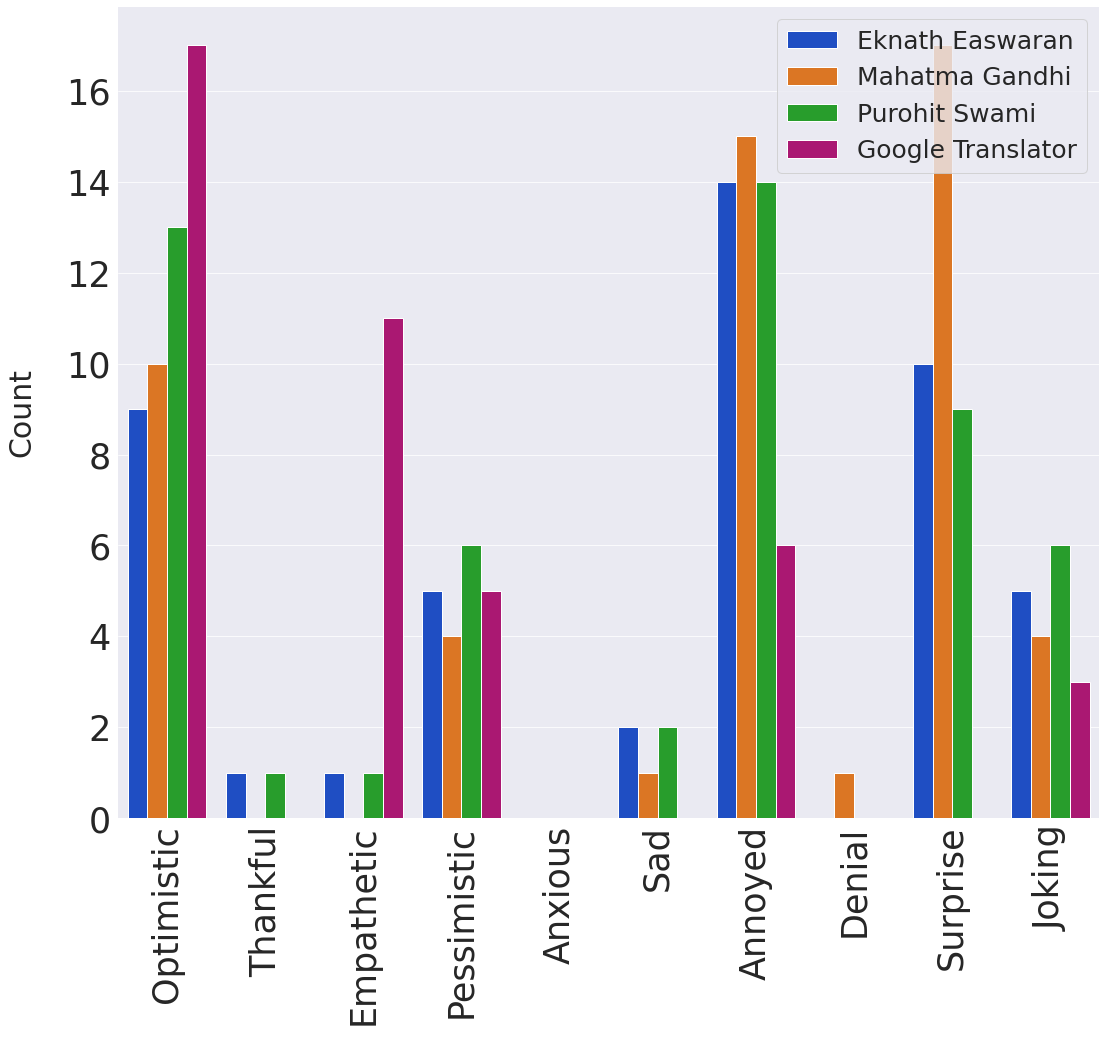

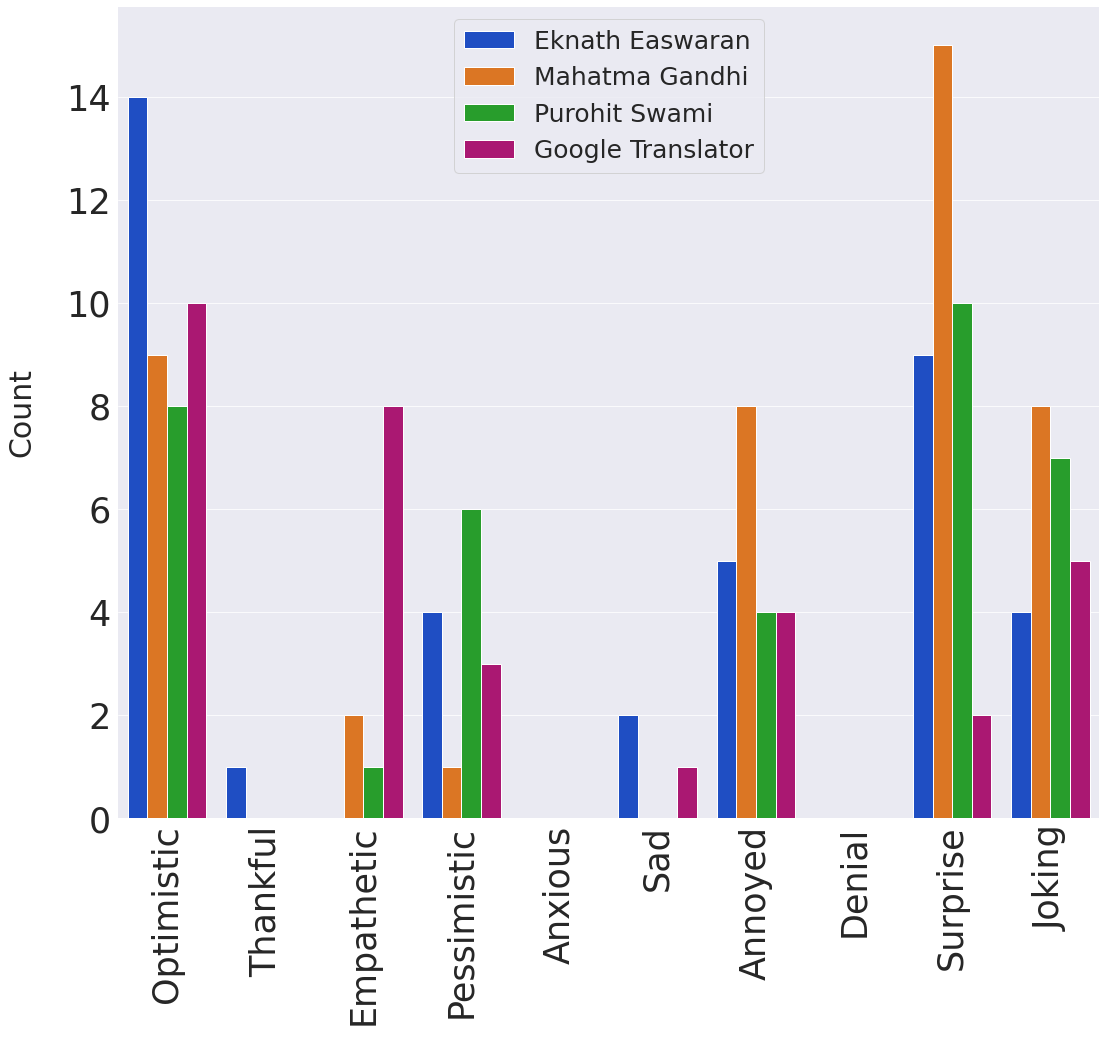

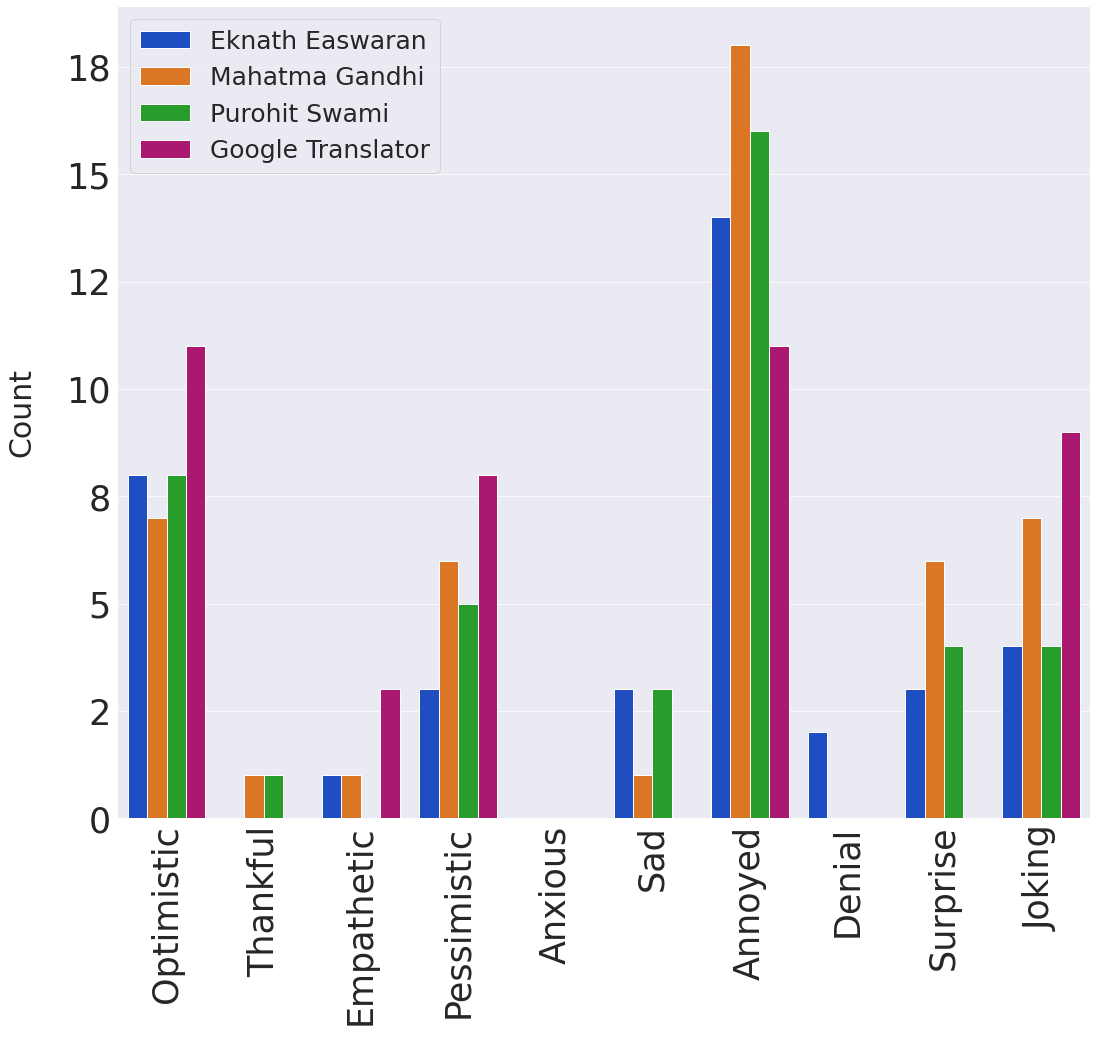

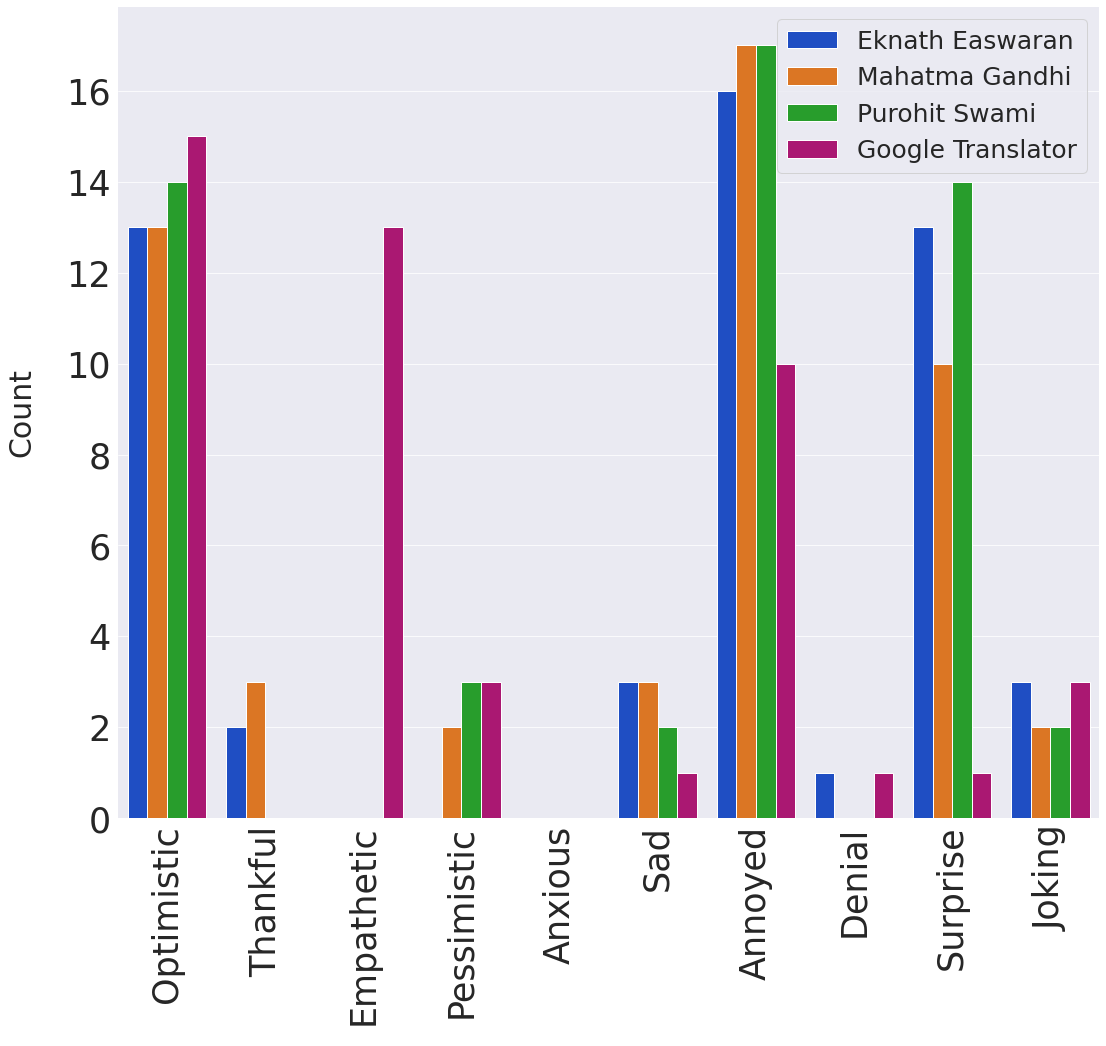

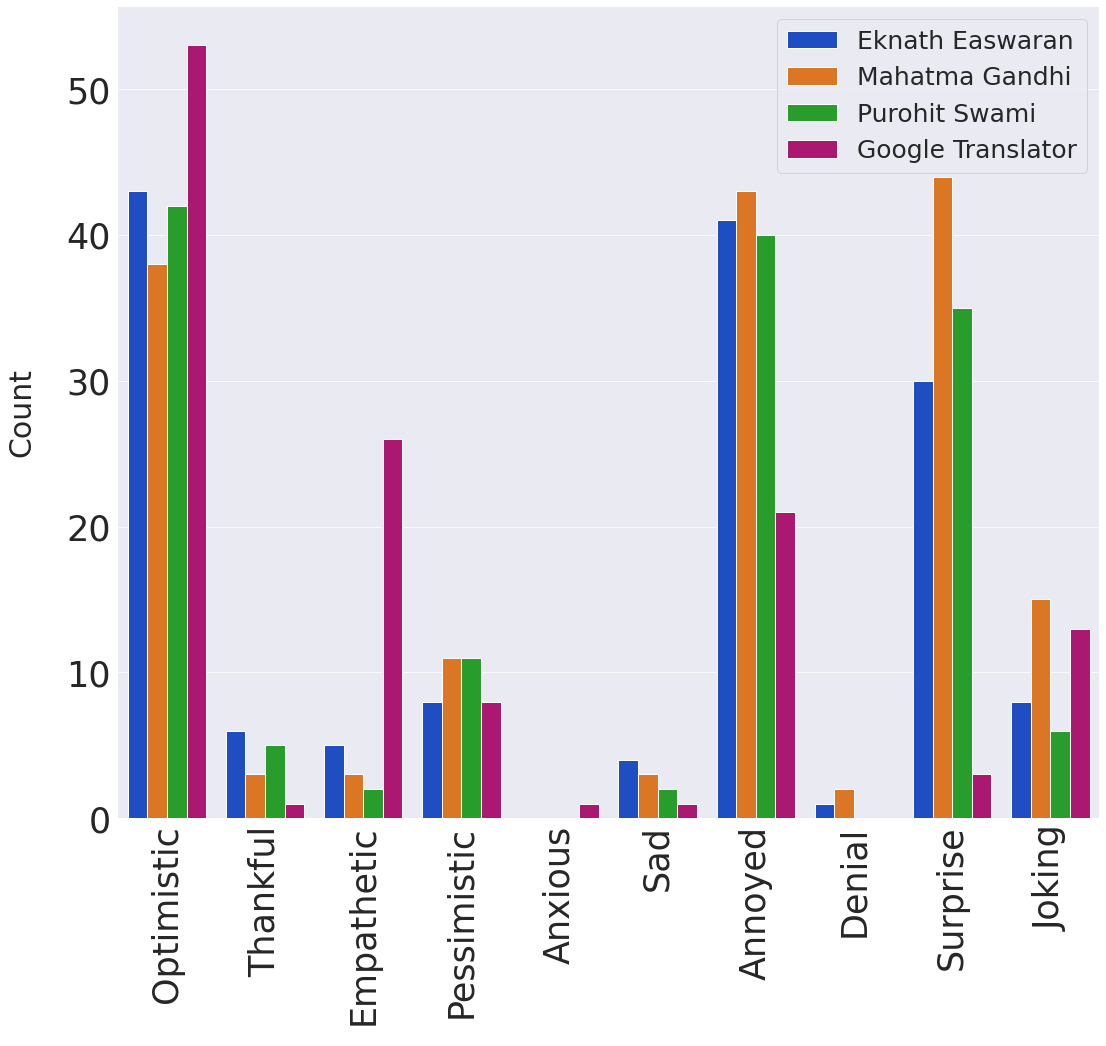

In [ ]:
for chapter in range(1,19):

  eknath_easwaran = chapter_wise_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter ', chapter)
  mahatma_gandhi = chapter_wise_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter ', chapter)
  purohit_swami = chapter_wise_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter ', chapter)
  google_translator =chapter_wise_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ', chapter)
  df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count'], google_translator['Count']], axis=1)

  df_new.columns = ['Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami', 'Google Translator'] 

  df_new = df_new.reset_index()

  df_new = df_new.rename(columns={"index":"Sentiment"})

  df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
  #df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Count", value_name="Author")
  colors = ["blue", "orange", "green","magenta"]  
  myPalette = sns.xkcd_palette(colors)

  sns.set_style("darkgrid")
  g = sns.factorplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', size=12, aspect=1.2, palette = myPalette, legend=False)

  g.despine(left=True)

  # if chapter == 1 or chapter == 2 or chapter == 3 or chapter == 16 or chapter==17:
  #   plt.legend(loc='upper left',prop={"size":25})

  # else:
  #   plt.legend(loc='upper center',prop={"size":25})

  plt.legend(loc='best',prop={"size":25})

  plt.ylabel('Count', labelpad=30, fontsize=30)
  plt.xlabel(' ')

  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
  plt.yticks(fontsize= 35)
  plt.xticks(fontsize = 35)
  plt.xticks(rotation=90)

In [ ]:
df_new.head()

Sentiment           Author  Count
0   Optimistic  Eknath Easwaran   43.0
1     Thankful  Eknath Easwaran    6.0
2   Empathetic  Eknath Easwaran    5.0
3  Pessimistic  Eknath Easwaran    8.0
4      Anxious  Eknath Easwaran    0.0

In [ ]:
df_new.reset_index()

index    Sentiment             Author  Count
0       0   Optimistic    Eknath Easwaran   43.0
1       1     Thankful    Eknath Easwaran    6.0
2       2   Empathetic    Eknath Easwaran    5.0
3       3  Pessimistic    Eknath Easwaran    8.0
4       4      Anxious    Eknath Easwaran    0.0
5       5          Sad    Eknath Easwaran    4.0
6       6      Annoyed    Eknath Easwaran   41.0
7       7       Denial    Eknath Easwaran    1.0
8       8     Surprise    Eknath Easwaran   30.0
9       9       Joking    Eknath Easwaran    8.0
10     10   Optimistic     Mahatma Gandhi   38.0
11     11     Thankful     Mahatma Gandhi    3.0
12     12   Empathetic     Mahatma Gandhi    3.0
13     13  Pessimistic     Mahatma Gandhi   11.0
14     14      Anxious     Mahatma Gandhi    0.0
15     15          Sad     Mahatma Gandhi    3.0
16     16      Annoyed     Mahatma Gandhi   43.0
17     17       Denial     Mahatma Gandhi    2.0
18     18     Surprise     Mahatma Gandhi   44.0
19     19       Joking     Mahatma Gandhi   15.0
20     20   Optimistic      Purohit Swami   42.0
21     21     Thankful      Purohit Swami    5.0
22     22   Empathetic      Purohit Swami    2.0
23     23  Pessimistic      Purohit Swami   11.0
24     24      Anxious      Purohit Swami    0.0
25     25          Sad      Purohit Swami    2.0
26     26      Annoyed      Purohit Swami   40.0
27     27       Denial      Purohit Swami    0.0
28     28     Surprise      Purohit Swami   35.0
29     29       Joking      Purohit Swami    6.0
30     30   Optimistic  Google Translator   53.0
31     31     Thankful  Google Translator    1.0
32     32   Empathetic  Google Translator   26.0
33     33  Pessimistic  Google Translator    8.0
34     34      Anxious  Google Translator    1.0
35     35          Sad  Google Translator    1.0
36     36      Annoyed  Google Translator   21.0
37     37       Denial  Google Translator    0.0
38     38     Surprise  Google Translator    3.0
39     39       Joking  Google Translator   13.0

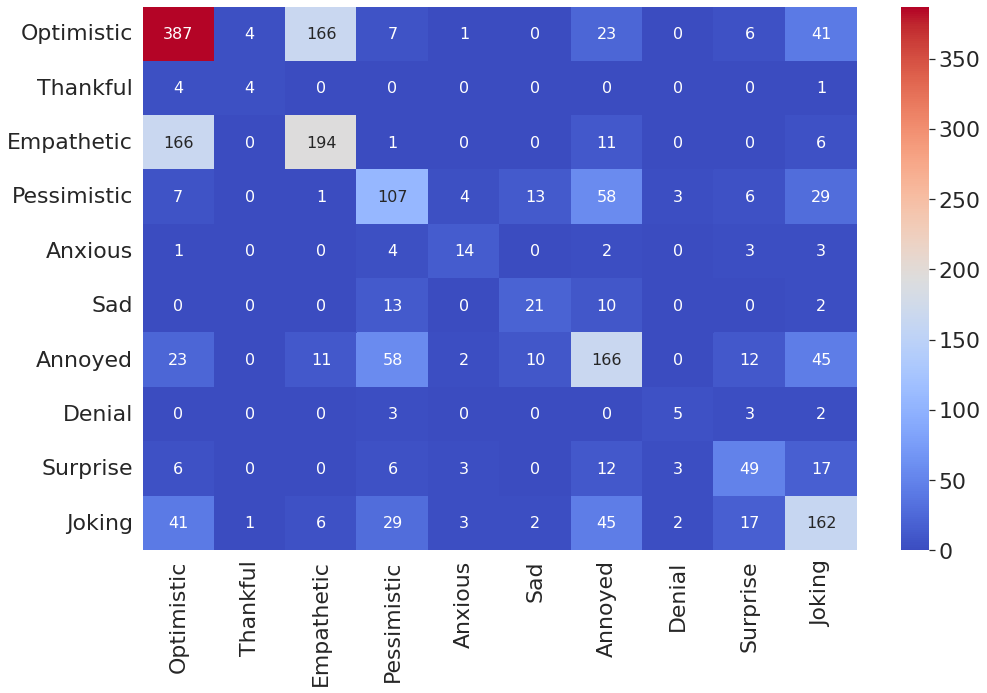

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 1')
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((10, 10))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7,
    'Surprise' : 8, 'Joking' : 9
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(10):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 10):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)

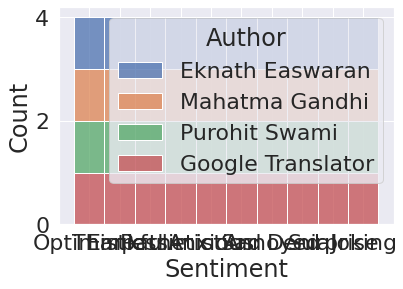

In [ ]:
eknath_easwaran = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter ')
mahatma_gandhi = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter ')
purohit_swami = all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter ')
google_translator =all_chapter_dataframe('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ')
df_new = pd.concat([eknath_easwaran, mahatma_gandhi['Count'], purohit_swami['Count'], google_translator['Count']], axis=1)

df_new.columns = ['Sentiment', 'Eknath Easwaran', 'Mahatma Gandhi', 'Purohit Swami', 'Google Translator'] 
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

sns.histplot(data= df_new, x='Sentiment', hue='Author', multiple= 'stack')


In [ ]:
df_new

Sentiment             Author  Count
0    Optimistic    Eknath Easwaran    345
1      Thankful    Eknath Easwaran     28
2    Empathetic    Eknath Easwaran     27
3   Pessimistic    Eknath Easwaran     94
4       Anxious    Eknath Easwaran      5
5           Sad    Eknath Easwaran     47
6       Annoyed    Eknath Easwaran    265
7        Denial    Eknath Easwaran     17
8      Surprise    Eknath Easwaran    282
9        Joking    Eknath Easwaran    133
10   Optimistic     Mahatma Gandhi    296
11     Thankful     Mahatma Gandhi     21
12   Empathetic     Mahatma Gandhi     18
13  Pessimistic     Mahatma Gandhi    116
14      Anxious     Mahatma Gandhi      9
15          Sad     Mahatma Gandhi     39
16      Annoyed     Mahatma Gandhi    359
17       Denial     Mahatma Gandhi     10
18     Surprise     Mahatma Gandhi    366
19       Joking     Mahatma Gandhi    165
20   Optimistic      Purohit Swami    323
21     Thankful      Purohit Swami     18
22   Empathetic      Purohit Swami     24
23  Pessimistic      Purohit Swami    108
24      Anxious      Purohit Swami      5
25          Sad      Purohit Swami     43
26      Annoyed      Purohit Swami    316
27       Denial      Purohit Swami      5
28     Surprise      Purohit Swami    325
29       Joking      Purohit Swami    128
30   Optimistic  Google Translator    387
31     Thankful  Google Translator      4
32   Empathetic  Google Translator    194
33  Pessimistic  Google Translator    107
34      Anxious  Google Translator     14
35          Sad  Google Translator     21
36      Annoyed  Google Translator    166
37       Denial  Google Translator      5
38     Surprise  Google Translator     49
39       Joking  Google Translator    162

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
eknath_easwaran_chapter_one = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter 1')
mahatma_gandhi_chapter_one = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter 1')
purohit_swami_chapter_one = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter 1')
google_translator_chapter_one = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 1')

eknath_easwaran_chapter_1 = eknath_easwaran_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
mahatma_gandhi_chapter_1 = mahatma_gandhi_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
purohit_swami_chapter_1 = purohit_swami_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
google_translator_chapter_1 = google_translator_chapter_one.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

In [ ]:
purohit_swami_chapter_one


Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   
37          37   
38          38   
39          39   
40          40   
41          41   
42          42   
43          43   
44          44   
45          45   
46          46   

                                                                                                                                                                  Tweet  \
0                     The King Dhritarashtra asked: “O Sanjaya! What happened on the sacred battlefield of Kurukshetra, when my people gathered against the Pandavas?”    
1                     Sanjaya replied: “The Prince Duryodhana, when he saw the army of the Pandavas paraded, approached his preceptor Guru Drona and spoke as follows:    
2                                                     Revered Father! Behold this mighty host of the Pandavas, paraded by the son of King Drupada, your wise disciple.    
3                                     In it are heroes and great bowmen; the equals in battle of Arjuna and Bheema, Yuyudhana, Virata and Drupada, great soldiers all;    
4                                                              Dhrishtaketu, Chekitan, the valiant King of Benares, Purujit, Kuntibhoja, Shaibya – a master over many;    
5                                                                                               Yudhamanyu, Uttamouja, Soubhadra and the sons of Droupadi, famous men.    
6       Further, take note of all those captains who have ranged themselves on our side, O best of Spiritual Guides! The leaders of my army. I will name them for you.    
7                                                        You come first; then Bheeshma, Karna, Kripa, great soldiers; Ashwaththama, Vikarna and the son of Somadhatta;    
8                                                                                        And many others, all ready to die for my sake; all armed, all skilled in war.    
9                                              Yet our army seems the weaker, though commanded by Bheeshma; their army seems the stronger, though commanded by Bheema.    
10                                        Therefore in the rank and file, let stand firm in their posts, according to battalions; and all you generals about Bheeshma.    
11                           Then to enliven his spirits, the brave Grandfather Bheeshma, eldest of the Kuru-clan, blew his conch, till it sounded like a lion’s roar.    
12                                                               And immediately all the conches and drums, the trumpets and horns, blared forth in tumultuous uproar.    
13                                       Then seated in their spacious war chariot, yoked with white horses, Lord Shri Krishna and Arjuna sounded their divine shells.    
14                                                          Lord Shri Krishna blew his Panchajanya and Arjuna his Devadatta, brave Bheema his renowned shell, Poundra.    
15                                        The King Dharmaraja, the son of Kunti, blew the Anantavijaya, Nakalu and Sahadeo, the Sugosh and Manipushpaka, respectively.    
16                                     And the Maharaja of Benares, the great archer, Shikhandi, the great soldier, Dhrishtayumna, Virata and Satyaki, the invincible,    
17                                                           

In [ ]:
google_translator_chapter_one


Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   
37          37   
38          38   
39          39   
40          40   
41          41   
42          42   
43          43   
44          44   
45          45   

                                                                                                                                                                                                        Tweet  \
0                                                 Dhṛtarāṣṭra said: O Sanjaya, what did the Pāṇḍavas and the Pāṇḍavas do with their festivities assembled in the field of Kurukṣetra in the field of Dharma?    
1                                                                Sanjaya saw the army of the Pāṇḍavas arranged at the army of the Pāṇḍavas and the king approached the ācārya and addressed him as follows      
2                                                                                                         O teacher look at this great army of the sons of Pāṇḍu by your wise disciple the son of Drupada       
3                                                                                     Here the great archer Bhīma and Arjuna are equal to Bhīma and Arjuna in battle Virata and Drupada the great charioteer    
4                                                                                                                  Dhrishtaketu and Chekitana were the mighty king of Kāśī and the mighty Purujit Kuntibhoja    
5                                                                                                   Yudhamanyu and Vikranta Uttamauja were the mighty Saubhadra and Draupadi and all the great charioteers      
6                                                                                                                                      O best of the brāhmaṇas listen to those who are distinguished by us      
7                                                                                                                         You are Bhishma Karna Kripa Samitinjaya Ashvatthama Vikarna and also Saumadatti       
8                                                                                                                      Many other brave men gave up their lives for My sake They were all experts in warfare    
9                                                                                                                                       The strength of ours is protected by Bhīma and is protected by Bhīma    
10                                                                                                                                       May all of you protect Bhishma in all the ayana in their proper way    
11                                                                                         The mighty grandfather of the Kurus shook the roar of the roar of the lion's conchshell and blew his conchshell      
12                                                                                              Then suddenly the sounds of the conches and the drums and the horns of the cowherd boys became tumultuous       
13                                                                                              Then the two divine conchshells, Mādhava and the Pāṇḍavas, arranged in a great chariot with white horses.       
14                    

In [ ]:
row = eknath_easwaran_chapter_1.iloc[46, :]
row

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
purohit_swami_chapter_1.iloc[46, :]

Optimistic     0.0
Thankful       0.0
Empathetic     0.0
Pessimistic    0.0
Anxious        0.0
Sad            0.0
Annoyed        0.0
Denial         0.0
Surprise       0.0
Joking         0.0
Name: 46, dtype: float64

In [ ]:
eknath_easwaran_chapter_1

Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0          0.0       0.0         0.0          0.0      0.0  0.0      1.0   
1          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
2          1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3          0.0       1.0         0.0          0.0      0.0  0.0      0.0   
4          1.0       1.0         0.0          0.0      0.0  0.0      0.0   
5          0.0       1.0         0.0          0.0      0.0  0.0      0.0   
6          1.0       1.0         0.0          0.0      0.0  0.0      0.0   
7          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
8          0.0       1.0         0.0          0.0      0.0  0.0      0.0   
9          0.0       0.0         0.0          1.0      0.0  0.0      1.0   
10         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
11         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
12         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
13         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
14         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
15         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
16         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
17         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
18         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
19         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
20         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
21         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
22         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
23         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
24         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
25         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
26         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
27         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
28         0.0       0.0         0.0          0.0      1.0  1.0      0.0   
29         0.0       0.0         0.0          0.0      1.0  1.0      0.0   
30         0.0       0.0         0.0          1.0      0.0  0.0      1.0   
31         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
32         0.0       0.0         0.0          1.0      0.0  0.0      1.0   
33         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
34         0.0       0.0         0.0          1.0      0.0  1.0      1.0   
35         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
36         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
37         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
38         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
39         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
40         0.0       0.0         0.0          1.0      0.0  1.0      1.0   
41         0.0       0.0         0.0          0.0      0.0  1.0      1.0   
42         0.0       0.0         0.0          1.0      0.0  1.0      1.0   
43         0.0       0.0         0.0          1.0      0.0  1.0      1.0   
44         0.0       0.0         0.0          0.0      0.0  0.0      1.0   
45         0.0       0.0         0.0          1.0      0.0  0.0      1.0   
46         0.0       0.0         0.0          0.0      0.0  0.0      0.0   

    Denial  Surprise  Joking  
0      0.0       1.0     0.0  
1      0.0       1.0     0.0  
2      0.0       0.0     0.0  
3      0.0       0.0     1.0  
4      0.0       0.0     0.0  
5      0.0       0.0     0.0  
6      0.0       0.0     0.0  
7      0.0       1.0     1.0  
8      0.0       0.0     0.0  
9      0.0       1.0     0.0  
10     0.0    

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [ ]:
for ii in range(0, google_translator_chapter_1.shape[0]):
  print(jaccard_score(eknath_easwaran_chapter_1.iloc[ii, :], google_translator_chapter_1.iloc[ii, :]))

0.3333333333333333
0.0
0.5
0.3333333333333333
0.0
0.0
1.0
0.3333333333333333
0.5
0.0
1.0
1.0
0.5
1.0
1.0
0.5
0.5
0.0
0.0
0.0
1.0
0.3333333333333333
0.6666666666666666
0.5
0.25
0.5
0.0
0.0
0.3333333333333333
0.2
1.0
0.0
0.0
0.3333333333333333
0.25
0.6666666666666666
1.0
0.5
0.3333333333333333
0.0
0.3333333333333333
1.0
0.6666666666666666
0.3333333333333333
0.0
0.0


In [ ]:
df_es_mg = pd.DataFrame()
df_es_ps = pd.DataFrame()
df_mg_ps = pd.DataFrame()

chapter_list = []
es_mg_list = []
es_ps_list = []
mg_ps_list = []
gg = []
pg = []
eg = []

sum1 =0
sum2=0
sum3=0

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue
  eknath_easwaran_chapter= pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter ' + str(chapter))
  mahatma_gandhi_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter ' + str(chapter))
  purohit_swami_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter '+ str(chapter))
  google_translator_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter '+ str(chapter))

  eknath_easwaran_chapter = eknath_easwaran_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  mahatma_gandhi_chapter = mahatma_gandhi_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  purohit_swami_chapter = purohit_swami_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)
  google_translator_chapter = google_translator_chapter.drop(['Unnamed: 0', 'Tweet', 'Official report'], axis=1)

  for ii in range(0, google_translator_chapter.shape[0]):
    es_ps_list.append(jaccard_score(google_translator_chapter.iloc[ii, :], purohit_swami_chapter.iloc[ii, :]))
    es_mg_list.append(jaccard_score(google_translator_chapter.iloc[ii, :], mahatma_gandhi_chapter.iloc[ii, :]))
    mg_ps_list.append(jaccard_score(eknath_easwaran_chapter.iloc[ii, :], google_translator_chapter.iloc[ii, :]))

  chapter_list.append(chapter)
  df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_mg2 = pd.DataFrame(es_mg_list, columns=['Google Gandhi'])
  df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)
  # df_es_mg.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/easwaran_gandhi/chapter ' + str(chapter) + '.csv')

  df_es_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_es_ps2 = pd.DataFrame(es_ps_list, columns=['Purohit Google'])
  df_es_ps = pd.concat([df_es_ps1, df_es_ps2], axis=1)
  # df_es_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/purohit_easwaran/chapter ' + str(chapter) + '.csv')

  df_mg_ps1 = pd.DataFrame(chapter_list, columns=['Chapter'])
  df_mg_ps2 = pd.DataFrame(mg_ps_list, columns=['Eknath Google'])
  df_mg_ps = pd.concat([df_mg_ps1, df_mg_ps2], axis=1)
  # df_mg_ps.to_csv('/content/drive/MyDrive/religious_texts/jaccard score of predicted sentiments/gandhi_purohit/chapter ' + str(chapter) + '.csv')
  gg.append(df_es_mg['Google Gandhi'].mean())
  df_es_mg3= pd.DataFrame(gg, columns=['Google Gandhi'])
  df_es_mg4=pd.concat([df_es_mg1, df_es_mg3], axis=1)

  pg.append(df_es_ps['Purohit Google'].mean())
  df_es_ps3= pd.DataFrame(pg, columns=['Purohit Google'])
  df_es_ps4=pd.concat([df_es_ps1, df_es_ps3], axis=1)

  eg.append(df_mg_ps['Eknath Google'].mean())
  df_mg_ps3= pd.DataFrame(eg, columns=['Eknath Google'])
  df_mg_ps4=pd.concat([df_mg_ps1, df_mg_ps3], axis=1)
  print('Chapter ', str(chapter), ' Average')

  print('Google Gandhi ', df_es_mg['Google Gandhi'].mean())
  print('Purohit Google ', df_es_ps['Purohit Google'].mean())
  print('Eknath Google ', df_mg_ps['Eknath Google'].mean())

  print('\n')

  sum1+=df_es_mg['Google Gandhi'].mean()
  sum2+=df_es_ps['Purohit Google'].mean()
  sum3+=df_mg_ps['Eknath Google'].mean()


Chapter  3  Average
Google Gandhi  0.4201550387596899
Purohit Google  0.3883720930232558
Eknath Google  0.4124031007751938


Chapter  5  Average
Google Gandhi  0.37476851851851856
Purohit Google  0.3731481481481482
Eknath Google  0.40138888888888885


Chapter  7  Average
Google Gandhi  0.3535947712418301
Purohit Google  0.36307189542483664
Eknath Google  0.3939542483660131


Chapter  8  Average
Google Gandhi  0.34153846153846146
Purohit Google  0.36243589743589744
Eknath Google  0.3776923076923077


Chapter  9  Average
Google Gandhi  0.3311991869918699
Purohit Google  0.35335365853658535
Eknath Google  0.34867886178861784


Chapter  10  Average
Google Gandhi  0.32435275080906156
Purohit Google  0.35105177993527514
Eknath Google  0.35784789644012943


Chapter  11  Average
Google Gandhi  0.3091315453384419
Purohit Google  0.3243295019157088
Eknath Google  0.3507662835249042


Chapter  12  Average
Google Gandhi  0.3151245551601423
Purohit Google  0.3230130486358244
Eknath Google  0.357947

In [ ]:
chapter_list

[3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17]

In [ ]:
sum1 = sum1/11
sum2 = sum2/11
sum3 = sum3/11

print('sum1 ', sum1)
print('sum2 ', sum2)
print('sum3 ', sum3)

sum1  0.3380593698567819
sum2  0.3472027622844041
sum3  0.36994825768372847


In [ ]:
df_es_mg1 = pd.DataFrame(chapter_list, columns=['Chapter'])
df_es_mg2 = pd.DataFrame(df_es_mg4, columns=['Google Gandhi'])

df_es_mg = pd.concat([df_es_mg1, df_es_mg2], axis=1)

df_es_mg

Chapter  Google Gandhi
0         3       0.420155
1         5       0.374769
2         7       0.353595
3         8       0.341538
4         9       0.331199
5        10       0.324353
6        11       0.309132
7        12       0.315125
8        15       0.309413
9        16       0.316051
10       17       0.323324

In [ ]:
df_final = pd.concat([df_es_mg, df_es_ps3['Purohit Google'],df_mg_ps3['Eknath Google']], axis=1)

df_final

Chapter  Google Gandhi  Purohit Google  Eknath Google
0         3       0.420155        0.388372       0.412403
1         5       0.374769        0.373148       0.401389
2         7       0.353595        0.363072       0.393954
3         8       0.341538        0.362436       0.377692
4         9       0.331199        0.353354       0.348679
5        10       0.324353        0.351052       0.357848
6        11       0.309132        0.324330       0.350766
7        12       0.315125        0.323013       0.357948
8        15       0.309413        0.319546       0.354374
9        16       0.316051        0.328000       0.359231
10       17       0.323324        0.332908       0.355146

In [ ]:
Easwaran_Gandhi_avg_score = df_final['Google Gandhi'].mean()
Purohit_Easwaran_avg_score = df_final['Purohit Google'].mean()
Purohit_Gandhi_avg_score = df_final['Eknath Google'].mean()

print(Easwaran_Gandhi_avg_score)
print(Purohit_Easwaran_avg_score)
print(Purohit_Gandhi_avg_score)

0.3380593698567819
0.34720276228440416
0.36994825768372847


In [ ]:
data=pd.melt(df_final, ['Chapter'])

In [ ]:
data

Chapter        variable     value
0         3   Google Gandhi  0.420155
1         5   Google Gandhi  0.374769
2         7   Google Gandhi  0.353595
3         8   Google Gandhi  0.341538
4         9   Google Gandhi  0.331199
5        10   Google Gandhi  0.324353
6        11   Google Gandhi  0.309132
7        12   Google Gandhi  0.315125
8        15   Google Gandhi  0.309413
9        16   Google Gandhi  0.316051
10       17   Google Gandhi  0.323324
11        3  Purohit Google  0.388372
12        5  Purohit Google  0.373148
13        7  Purohit Google  0.363072
14        8  Purohit Google  0.362436
15        9  Purohit Google  0.353354
16       10  Purohit Google  0.351052
17       11  Purohit Google  0.324330
18       12  Purohit Google  0.323013
19       15  Purohit Google  0.319546
20       16  Purohit Google  0.328000
21       17  Purohit Google  0.332908
22        3   Eknath Google  0.412403
23        5   Eknath Google  0.401389
24        7   Eknath Google  0.393954
25        8   Eknath Google  0.377692
26        9   Eknath Google  0.348679
27       10   Eknath Google  0.357848
28       11   Eknath Google  0.350766
29       12   Eknath Google  0.357948
30       15   Eknath Google  0.354374
31       16   Eknath Google  0.359231
32       17   Eknath Google  0.355146

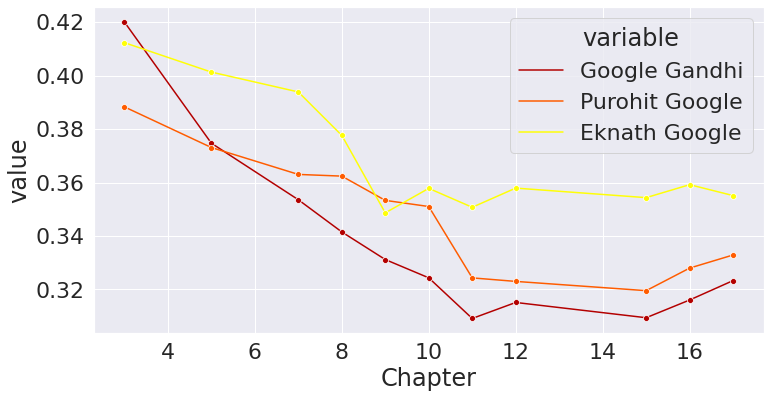

In [ ]:
sns.set_style("darkgrid")

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.lineplot(x='Chapter', y='value', hue='variable', data=data, ax = ax)

sns.lineplot(x='Chapter',y='value',  hue = 'variable', data=data,
             palette = 'hot', dashes= False, marker= 'o', ax=ax)

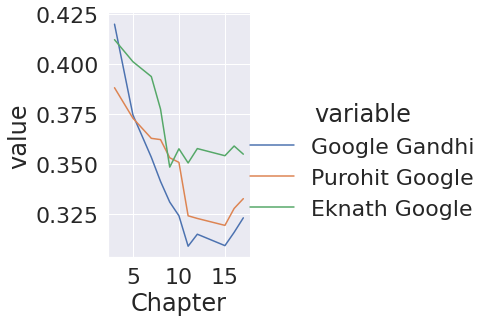

In [ ]:
sns.relplot(x="Chapter", y="value", hue="variable",
            dashes=False, markers=True, kind="line", data=data)

In [ ]:
sentiment_polarity = {
    'Surprise': 0,
    'Joking': 0,
    'Pessimistic': -1,
    'Anxious': -1,
    'Sad':  -1,
    'Annoyed': -1,
    'Denial': -1,
    'Optimistic': 1,
    'Thankful': 1,
    'Empathetic': 1
}

In [ ]:
!python3.7 -m pip install --upgrade pip
!pip install chart_studio
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plotly to create interactive graph
import chart_studio.plotly as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import chart_studio.plotly as py
from plotly import tools
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=False)
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# To remove un-necessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

In [ ]:
array_of_array = [[20,21,22, 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45], [3,4,5,6,7, 53], [0,1,35], [3], [0], [32,33,36,37,38], [], [0,1], [], 
                  [11,12,13,14,15,16,17], [0,1,2,3,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40,41,42,43,44,45],[0], [],[20],[],[],[0],
                  [0,72]]

polarity = 0
count = 0

polarity_array = []
chapter = 1
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])

for array in array_of_array:

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

  polarity = 0
  if len(array)!=0:

    for element in array:
      df1 = eknath_easwaran_chapter.loc[element, :]
      if df1['Optimistic'] == 1 :
        count+=1
        polarity+=1

      if df1['Thankful'] == 1 :
        count+=1
        polarity+=1

      if df1['Empathetic'] == 1 :
        count+=1
        polarity+=1

      if df1['Denial'] == 1 :
        count+=1
        polarity -= 1 

      if df1['Annoyed'] == 1 :
        count+=1
        polarity -= 1

      if df1['Sad'] == 1 :
        count+=1
        polarity -= 1

      if df1['Anxious'] == 1 :
        count+=1
        polarity -= 1

      if df1['Pessimistic'] == 1 :
        count+=1
        polarity -= 1

      if df1['Joking'] == 1 :
        #count+=1
        polarity+=0

      if df1['Surprise'] == 1 :
        #count+=1
        polarity+=0

  df_temp = pd.DataFrame([[chapter, polarity]], columns = ['Chapter', 'Polarity'])
  df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index = True)
  chapter+=1

df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')


Polarity
Chapter         
1            -28
2             -1
3             -1
4             -1
5              0
6             -2
7              0
8             -3
9              0
10             3
11            15
12             2
13             0
14             1
15             0
16             0
17             0
18             4

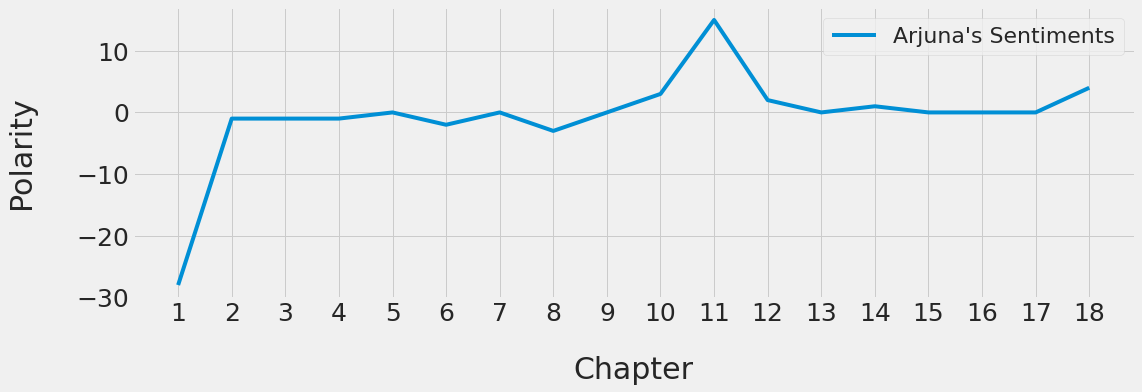

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.lineplot(x = df_sentiments['Chapter'], y = df_sentiments['Polarity'], label='Arjuna\'s Sentiments')
p6.set_xlabel("Verses Where Arjuna Speaks")

plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Chapter', labelpad=30, fontsize=30)

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(np.arange(1, 19, step=1), fontsize = 25)

plt.show()

In [ ]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)

    return new_list

In [ ]:
array = flatten([2,3, range(11, 54), range(55, 73)])
print(array)

[2, 3, range(11, 54), range(55, 73)]


In [ ]:
array_of_array

[[20,
  21,
  22,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 [3, 4, 5, 6, 7, 53],
 [0, 1, 35],
 [3],
 [0],
 [32, 33, 36, 37, 38],
 [],
 [0, 1],
 [],
 [11, 12, 13, 14, 15, 16, 17],
 [0,
  1,
  2,
  3,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 [0],
 [],
 [20],
 [],
 [],
 [0],
 [0, 72]]

In [ ]:
array_of_array = [[], flatten([2,3, list(np.arange(11, 54)), list(np.arange(55, 71))]), flatten([list(np.arange(3,36)), list(np.arange(37,43))]), 
                    flatten([1,2,3, list(np.arange(5, 43))]),
                      flatten([list(np.arange(2, 30))]),
                        flatten([list(np.arange(1,33)), 35,36, list(np.arange(40,48))]),
                          flatten([list(np.arange(1,31))]),
                            flatten([list(np.arange(2,29))]),
                              flatten([list(np.arange(1,35))]),
                                flatten([list(np.arange(1,12)), list(np.arange(19,43))]),
                                  flatten([5,6,7,8, 32,33,34,47,48,49,52,53,54,55]),
                                    flatten([list(np.arange(2,21))]),
                                      flatten([list(np.arange(1,35))]),
                                        flatten([list(np.arange(1,21)),22,23,24,25,26,27]),
                                          flatten([list(np.arange(1,21))]),
                                            flatten([list(np.arange(1,25))]),
                                              flatten([list(np.arange(2,29))]),
                                                flatten([list(np.arange(2,73))])]

polarity = 0
count = 0

polarity_array = []
chapter = 1
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])

for array in array_of_array:

  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

  polarity = 0
  if len(array)!=0:

    for element in array:
      df1 = eknath_easwaran_chapter.loc[element-1, :]
      if df1['Optimistic'] == 1 :
        count+=1
        polarity+=1

      if df1['Thankful'] == 1 :
        count+=1
        polarity+=1

      if df1['Empathetic'] == 1 :
        count+=1
        polarity+=1

      if df1['Denial'] == 1 :
        count+=1
        polarity -= 1 

      if df1['Annoyed'] == 1 :
        count+=1
        polarity -= 1

      if df1['Sad'] == 1 :
        count+=1
        polarity -= 1

      if df1['Anxious'] == 1 :
        count+=1
        polarity -= 1

      if df1['Pessimistic'] == 1 :
        count+=1
        polarity -= 1

      if df1['Joking'] == 1 :
        #count+=1
        polarity+=0

      if df1['Surprise'] == 1 :
        #count+=1
        polarity+=0

  df_temp = pd.DataFrame([[chapter, polarity]], columns = ['Chapter', 'Polarity'])
  df_sentiments = pd.concat([df_temp, df_sentiments], axis=0, ignore_index = True)
  chapter+=1

df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')

Polarity
Chapter         
1              0
2              4
3              2
4             22
5              7
6             26
7              8
8             21
9             25
10            20
11            10
12            16
13            28
14            16
15            10
16            -5
17            13
18            38

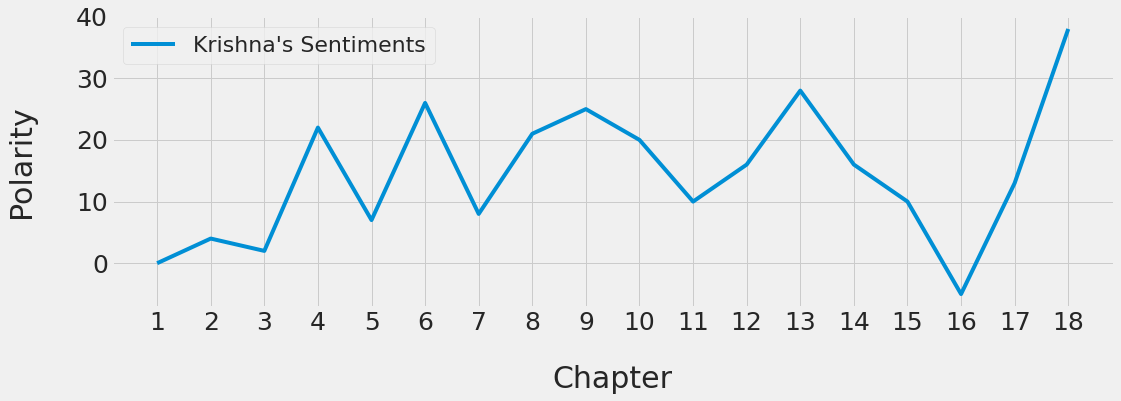

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,5))
p6=sns.lineplot(x = df_sentiments['Chapter'], y = df_sentiments['Polarity'], label='Krishna\'s Sentiments')
p6.set_xlabel("Verses Where Shri Krishna Speaks")

plt.ylabel('Polarity', labelpad=40, fontsize=30)
plt.xlabel('Chapter', labelpad=30, fontsize=30)

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(np.arange(1, 19, step=1), fontsize = 25)

plt.show()

In [ ]:
eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 18')
eknath_easwaran_chapter = eknath_easwaran_chapter.drop(['Unnamed: 0', 'Official report'], axis=1)

eknath_easwaran_chapter.tail(50)

Tweet  \
28                                                                                        O Arjuna, O Arjuna, please hear about the threefold differences between intelligence and the modes of nature. .   
29                                                                                               The intellect which knows that instinct and renunciation is in action, in action, in fear and in fear. .   
30                                                                           That intelligence which perceives religious principles and irreligion and activity and acts in unrighteousness is Rajasic  ॥   
31                                                      That intelligence which thinks that irreligion thinks that it is religious and is enveloped in darkness and that is the opposite of all things  ॥   
32                                                          By the patience of the mind, the mind, the life force, the senses, the cessation of yoga, O son of Pṛthā, are the modes of material nature. .   
33                                           O Arjuna, by which one who holds the path of religious principles and desires by patience in this regard is Rajasic for patience for the sake of rewards.  ॥   
34                                                                                              O son of Pṛthā, that patience which does not give up dreams, fear, sorrow, depression and intoxication. .   
35                                            O best of the Bharatas, please hear from me about the happiness of the three worlds, and now the practice of practicing is enjoying the end of the world. .   
36                      That which is like poison in the past is like nectar in the past, and that happiness is described in the mode of goodness, which is born of the grace of the self-intelligence. .   
37                                                                                                  The union of the senses of objects is like nectar in the foreground, just as poison is like poison. .   
38                                                  The happiness of the self, which is the source of all happiness, which is deluded by the self-realized soul, is described in the mode of ignorance. .   
39                                 There is no such thing on earth or in heaven or among the demigods. Therefore, the Supreme Personality of Godhead is freed from the three modes of material nature.  ॥   
40  O lord of the enemies of the enemy of the enemy of the enemies of the universe, the Supreme Personality of Godhead, who is the source of all living entities, is the source of all living entities. .   
41                                                             Relief, self-control, self-control, purity, forbearance, simplicity, knowledge, realization, atheism, ceremonial activities and nature.  ॥   
42                                                                          Valour, splendor, patience, dexterity, escape in battle, charity, alms and kṣatriyas are the kṣatriyas of their own nature. .   
43                                                                  Agricultural, cattle, trade, trade, vaiśya and vaiśya are the same as those of the śūdras, which are the same as those of a śūdra.  ॥   
44                                          One who is engaged in his own activities and who is engaged in his own activities attains perfection in his own activities. Hear how he attains perfection. .   
45                                                       By worshiping the Supreme Personality of Godhead, one attains perfection by His own activities. By His own activities, one attains perfection. .   
46                           One who is free from the modes of material nature and who is self-realized by one’s own religious practices should not perform any sinful activities for one’s own nature. .   
47                                   O son of Kunti, one should not abandon the easy activity, e

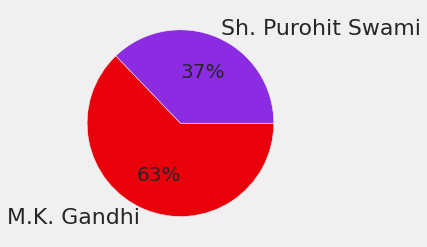

In [ ]:
data = [671, 397]
labels = ['M.K. Gandhi', 'Sh. Purohit Swami']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[3:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', counterclock = False)
plt.show()

In [ ]:
df_chapter_12 = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 12')
df_chapter_12.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)

In [ ]:
df_chapter_12_optimistic = df_chapter_12.loc[(df_chapter_12['Optimistic'] == 1)]
df_chapter_12_annoyed = df_chapter_12.loc[(df_chapter_12['Annoyed'] == 1)]

df_chapter_12_annoyed

Tweet  \
9                                       You are unable to practice My activities and be devoted to My activities You will attain perfection even for My sake. .   
10               If you are unable to do this, you should renounce the fruits of all my actions. Therefore, you should renounce all the fruits of my actions. .   
15  He who is indifferent to Me, who is indifferent, indifferent, indifferent, indifferent, renounces all beginnings and who is devoted to Me is dear to Me.  ॥   

    Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
9          1.0       0.0         0.0          1.0      0.0  0.0      1.0   
10         0.0       0.0         0.0          1.0      0.0  0.0      1.0   
15         0.0       0.0         1.0          0.0      0.0  0.0      1.0   

    Denial  Surprise  Joking  
9      0.0       0.0     0.0  
10     0.0       0.0     0.0  
15     0.0       0.0     0.0

In [ ]:
import gensim
from gensim import utils
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Analysis Results/Sentiment Predictions/eknath easwaran/chapter 1')
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Analysis Results/Sentiment Predictions/eknath easwaran/chapter ' + str(chapter))

  df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

  topic_df = pd.concat([topic_df, df], axis=0)


In [ ]:
topic_df

Tweet  \
0                                  DHRITARASHTRA:  O Sanjaya, tell me what happened at Kurukshetra, the field of dharma, where my family and the Pandavas gathered to fight.    
1                                       SANJAYA:  Having surveyed the forces of the Pandavas arrayed for battle, prince Duryodhana approached his teacher, Drona, and spoke.    
2                                                               O my teacher, look at this mighty army of the Pandavas, assembled by your own gifted disciple, Yudhishthira.    
3                                                 There are heroic warriors and great archers who are the equals of Bhima and Arjuna: Yuyudhana, Virata, the mighty Drupada,    
4                                                                          Dhrishtaketu, Chekitana, the valiant king of Kashi, Purujit, Kuntibhoja,the great leader Shaibya,    
..                                                                                                                                                                        ...   
73    SANJAYA:  This is the dialogue I heard between Krishna, the son of Vasudeva, and Arjuna, the great-hearted son of Pritha. The wonder of it makes my hair stand on end!    
74                                                 Through Vyasas grace, I have heard the supreme secret of spiritual union directly from the Lord of Yoga, Krishna himself.    
75                                                                         Whenever I remember these wonderful, holy words between Krishna and Arjuna, I am filled with joy.    
76                                                                       And when I remember the breathtaking form of Krishna, I am filled with wonder and my joy overflows.    
77                              Wherever the divine Krishna and the mighty Arjuna are, there will be prosperity, victory, happiness, and sound judgment. Of this I am sure!     

    Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0          0.0       0.0         0.0          0.0      0.0  0.0      1.0   
1          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
2          1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3          0.0       1.0         0.0          0.0      0.0  0.0      0.0   
4          1.0       1.0         0.0          0.0      0.0  0.0      0.0   
..         ...       ...         ...          ...      ...  ...      ...   
73         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
74         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
75         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
76         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
77         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

    Denial  Surprise  Joking  
0      0.0       1.0     0.0  
1      0.0       1.0     0.0  
2      0.0       0.0     0.0  
3      0.0       0.0     1.0  
4      0.0       0.0     0.0  
..     ...       ...     ...  
73     0.0       1.0     1.0  
74     0.0       1.0     0.0  
75     0.0       0.0     1.0  
76     0.0       0.0     1.0  
77     0.0       0.0     0.0  

[699 rows x 11 columns]

In [ ]:
stop_words = stopwords.words('english')
newStopWords = ["shri", "replied", "asked", "shall", "lord", "said"]
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))


def preprocessing(df):

  df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
  df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")                                   # Remove punctuations
  df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
  df['Tweet tokens'] = list(tokenize(df['Tweet']))
  df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
  df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
  return df

def retrieve_text(df):
  doc = '. '.join(df['tokens_no_stop_joined'])
  return doc

def ngrams_series_func(data, n):
  
  wordList = re.sub("[^\w]", " ",  data).split()
  ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
  return ngrams_series

In [ ]:
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [ ]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
topic_df = preprocessing(topic_df)
topic_df

Tweet  \
0     dhritarashtra sanjaya tell what happened kurukshetra field dharma where family pandavas gathered fight   
1    sanjaya having surveyed forces pandavas arrayed battle prince duryodhana approached teacher drona spoke   
2                         teacher look this mighty army pandavas assembled your gifted disciple yudhishthira   
3                    there heroic warriors great archers equals bhima arjuna yuyudhana virata mighty drupada   
4                          dhrishtaketu chekitana valiant king kashi purujit kuntibhoja great leader shaibya   
..                                                                                                       ...   
73  sanjaya this dialogue heard between krishna vasudeva arjuna great hearted pritha wonder makes hair stand   
74    through vyasas grace have heard supreme secret spiritual union directly from lord yoga krishna himself   
75                           whenever remember these wonderful holy words between krishna arjuna filled with   
76                                      when remember breathtaking form krishna filled with wonder overflows   
77    wherever divine krishna mighty arjuna there will prosperity victory happiness sound judgment this sure   

    Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0          0.0       0.0         0.0          0.0      0.0  0.0      1.0   
1          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
2          1.0       0.0         0.0          0.0      0.0  0.0      0.0   
3          0.0       1.0         0.0          0.0      0.0  0.0      0.0   
4          1.0       1.0         0.0          0.0      0.0  0.0      0.0   
..         ...       ...         ...          ...      ...  ...      ...   
73         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
74         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
75         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
76         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
77         1.0       0.0         0.0          0.0      0.0  0.0      0.0   

    Denial  Surprise  Joking  \
0      0.0       1.0     0.0   
1      0.0       1.0     0.0   
2      0.0       0.0     0.0   
3      0.0       0.0     1.0   
4      0.0       0.0     0.0   
..     ...       ...     ...   
73     0.0       1.0     1.0   
74     0.0       1.0     0.0   
75     0.0       0.0     1.0   
76     0.0       0.0     1.0   
77     0.0       0.0     0.0   

                                                                                                                Tweet tokens  \
0       [dhritarashtra, sanjaya, tell, what, happened, kurukshetra, field, dharma, where, family, pandavas, gathered, fight]   
1      [sanjaya, having, surveyed, forces, pandavas, arrayed, battle, prince, duryodhana, approached, teacher, drona, spoke]   
2                             [teacher, look, this, mighty, army, pandavas, assembled, your, gifted, disciple, yudhishthira]   
3                       [there, heroic, warriors, great, archers, equals, bhima, arjuna, yuyudhana, virata, mighty, drupada]   
4                               [dhrishtaketu, chekitana, valiant, king, kashi, purujit, kuntibhoja, great, leader, shaibya]   
..                                                                                                                       ...   
73  [sanjaya, this, dialogue, heard, between, krishna, vasudeva, arjuna, great, hearted, pritha, wonder, makes, hair, stand]   
74    [through, vyasas, grace, have, heard, supreme, secret, spiritual, union, directly, from, lord, yoga, krishna, himself]   
75                               [whenever, remember, these, wonderful, holy, words, between, krishna, arjuna, filled, with]   
76                                            [when, remember, breathtaking, form, krishna, filled, with, wonder, overflows]   
77     [wherever, divine, krishna, mighty, arjuna, t

In [ ]:
text = retrieve_text(topic_df)
print(text)

dhritarashtra sanjaya tell happened kurukshetra field dharma family pandavas gathered fight. sanjaya surveyed forces pandavas arrayed battle prince duryodhana approached teacher drona spoke. teacher look mighty army pandavas assembled gifted disciple yudhishthira. heroic warriors great archers equals bhima arjuna yuyudhana virata mighty drupada. dhrishtaketu chekitana valiant king kashi purujit kuntibhoja great leader shaibya. powerful yudhamanyu valiant uttamaujas subhadra addition sons draupadi command mighty chariots. best brahmins listen names distinguished among forces. bhishma karna victorious kripa ashvatthama vikarna somadatta. many others heroes giving lives sake proficient armed variety weapons. army unlimited commanded bhishma small commanded bhima. everyone take proper place stand firm supporting bhishma. powerful bhishma grandsire oldest kurus order cheer duryodhana roared like lion blew conch horn. bhishma tremendous noise arose conchs horns pounding drums. krishna arjuna

Text(0, 0.5, '')

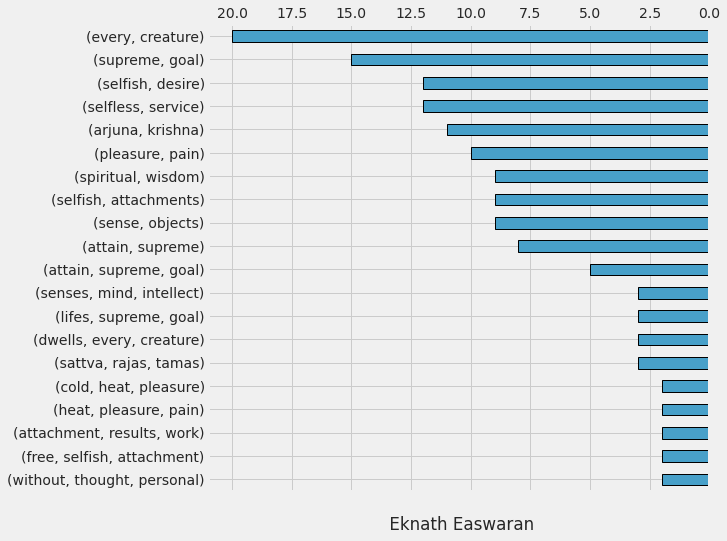

In [ ]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)



ngram1 = pd.concat([bigram1, trigram1])


plt.rcParams.update({'font.size': 14})
#fig, ax=plt.subplots(1,2, figsize=(16,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
fig, ax=plt.subplots(1,1, figsize=(8,8))

#barh_ax = ax[0]
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Eknath Easwaran')
barh_ax.set_ylabel('',fontsize=50)

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 1')
topic_df = topic_df.drop(['Unnamed: 0', 'Official report'], axis=1)

for chapter in range(2, 19):
  df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' + str(chapter))

  df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

  topic_df = pd.concat([topic_df, df], axis=0)

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))


def preprocessing(df):

  df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
  df['Tweet'] = df['Tweet'].str.replace("[^a-zA-Z#]", " ")                                   # Remove punctuations
  df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
  df['Tweet tokens'] = list(tokenize(df['Tweet']))
  df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
  df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
  return df

def retrieve_text(df):
  doc = '. '.join(df['tokens_no_stop_joined'])
  return doc

def ngrams_series_func(data, n):
  
  wordList = re.sub("[^\w]", " ",  data).split()
  ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:10]
  return ngrams_series

In [ ]:
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


In [ ]:
topic_df = preprocessing(topic_df)
topic_df

Tweet  \
0                  said sanjaya what avas avas with their festivities assembled field kuruk etra field dharma   
1                                      sanjaya army avas arranged army avas king approached addressed follows   
2                                                teacher look this great army sons your wise disciple drupada   
3                                here great archer arjuna equal arjuna battle virata drupada great charioteer   
4                                           dhrishtaketu chekitana were mighty king mighty purujit kuntibhoja   
..                                                                                                        ...   
73                                          thus heard this wonderful conversation between lord sudeva arjuna   
74                      grace have heard this supreme secret mystic yoga lord mystics lord directly described   
75                                              king remember this wonderful conversation between lord arjuna   
76       king very much astonished rejoicing this remembering this wonderful form supreme personality godhead   
77  wherever lord master yoga there lord opulence lord goddess fortune victory victory bhuti dhruva niti mati   

    Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
1          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
2          1.0       0.0         1.0          0.0      0.0  0.0      0.0   
3          0.0       0.0         0.0          0.0      0.0  0.0      0.0   
4          0.0       0.0         0.0          0.0      0.0  0.0      1.0   
..         ...       ...         ...          ...      ...  ...      ...   
73         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
74         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
75         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
76         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
77         1.0       0.0         1.0          0.0      0.0  0.0      0.0   

    Denial  Surprise  Joking  \
0      0.0       1.0     1.0   
1      0.0       0.0     1.0   
2      0.0       0.0     0.0   
3      0.0       1.0     1.0   
4      0.0       0.0     1.0   
..     ...       ...     ...   
73     0.0       0.0     1.0   
74     0.0       0.0     0.0   
75     0.0       0.0     1.0   
76     0.0       0.0     0.0   
77     0.0       0.0     1.0   

                                                                                                                  Tweet tokens  \
0                    [said, sanjaya, what, avas, avas, with, their, festivities, assembled, field, kuruk, etra, field, dharma]   
1                                            [sanjaya, army, avas, arranged, army, avas, king, approached, addressed, follows]   
2                                                      [teacher, look, this, great, army, sons, your, wise, disciple, drupada]   
3                                     [here, great, archer, arjuna, equal, arjuna, battle, virata, drupada, great, charioteer]   
4                                                   [dhrishtaketu, chekitana, were, mighty, king, mighty, purujit, kuntibhoja]   
..                                                                                                                         ...   
73                                                 [thus, heard, this, wonderful, conversation, between, lord, sudeva, arjuna]   
74                         [grace, have, heard, this, supreme, secret, mystic, yoga, lord, mystics, lord, directly, described]   
75                                                      [king, remember, this, wonderful, conversation, between, lord, arjuna]   
76          [king, very, much, astonished, rejoicing, this, remembering, this, wonderful, form, supreme, personality, godhead]   
77  [wherever, lord

In [ ]:
df_optimistic = topic_df[topic_df['Optimistic'] == 1]
df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
df_surprise = topic_df[topic_df['Surprise'] == 1]
df_denial = topic_df[topic_df['Denial'] == 1]
df_annoyed = topic_df[topic_df['Annoyed'] == 1]
df_thankful = topic_df[topic_df['Thankful'] == 1]
df_empathetic = topic_df[topic_df['Empathetic'] == 1]
df_anxious = topic_df[topic_df['Anxious'] == 1]
df_sad =  topic_df[topic_df['Sad'] == 1]
df_joking = topic_df[topic_df['Joking'] == 1]

In [ ]:
text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
text_surprise = '. '.join(df_surprise.tokens_no_stop_joined)
text_denial = '. '.join(df_denial.tokens_no_stop_joined)
text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
text_sad = '. '.join(df_sad.tokens_no_stop_joined)
text_joking = '. '.join(df_joking.tokens_no_stop_joined)

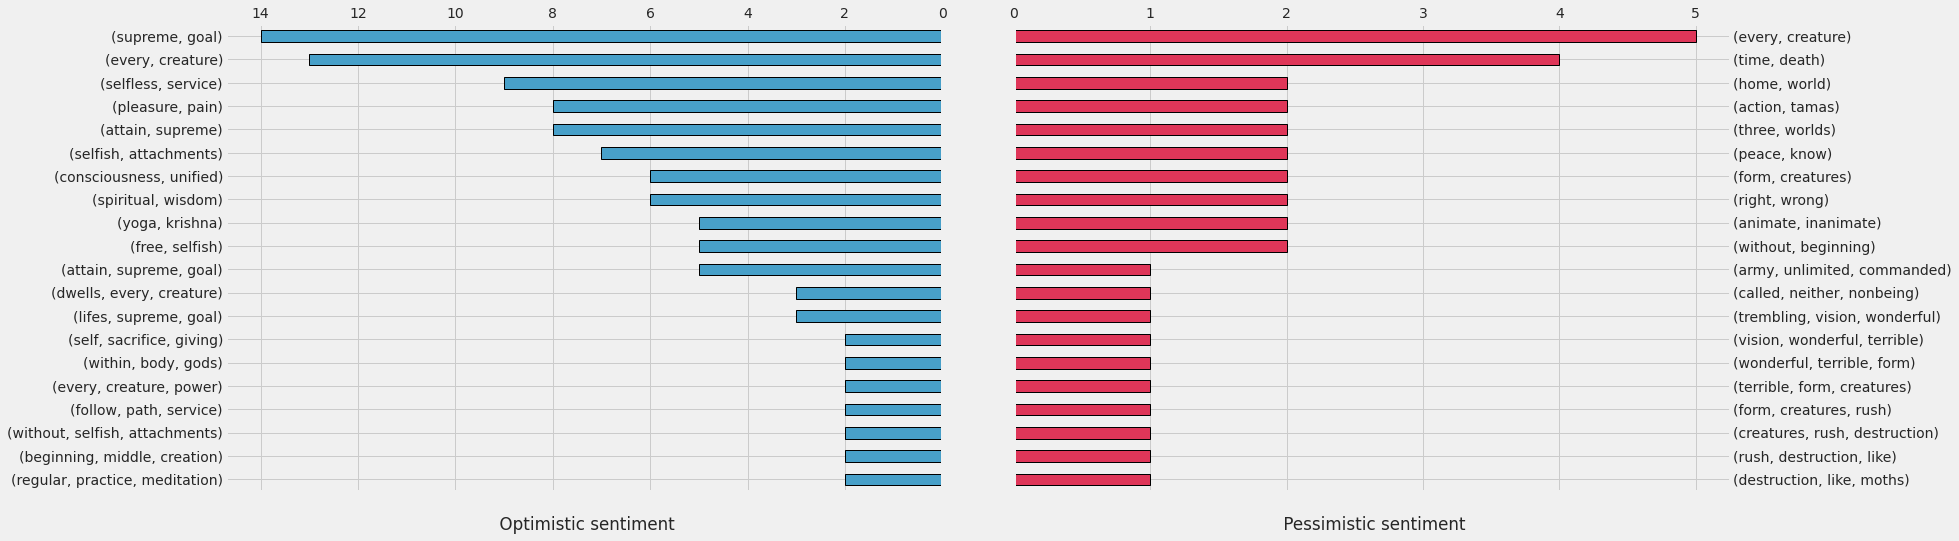

In [ ]:
bigram1 = ngrams_series_func(text_optimistic, 2)
trigram1 = ngrams_series_func(text_optimistic, 3)

# print(bigram1)

bigram2 = ngrams_series_func(text_pessimistic, 2)
trigram2 = ngrams_series_func(text_pessimistic, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,2, figsize=(24,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)
#barh_ax.set_xticks([0,0.5,1,1.5,2.0,2.5,3], minor=False)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
# barh_ax.set_xlabel('Tri N-gram Count - Trump Dataset', fontsize=13)
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
plt.show()

In [ ]:
eknath_easwaran_6 = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter 6')
mahatma_gandhi_6 = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter 6')
purohit_swami_6 = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter 6')
google_translator_6=pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 6')

In [ ]:
eknath_easwaran_6.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)
eknath_easwaran_6

Tweet  \
0                                                                KRISHNA:  It is not those who lack energy or refrain from action, but those who work without expectation of reward who attain the goal of meditation. Theirs is true renunciation.    
1                                         Therefore, Arjuna, you should understand that renunciation and the performance of selfless service are the same. Those who cannot renounce attachment to the results of their work are far from the path.    
2                                                                              For aspirants who want to climb the mountain of spiritual awareness, the path is selfless work; for those who have ascended to yoga the path is stillness and peace.    
3                                                                                     When a person has freed himself from attachment to the results of work, and from desires for the enjoyment of sense objects, he ascends to the unitive state.    
4                                                                Reshape yourself through the power of your will; never let yourself be degraded by self-will. The will is the only friend of the Self, and the will is the only enemy of the Self.    
5                                                                                                               To those who have conquered themselves, the will is a friend. But it is the enemy of those who have not found the Self within them.    
6                                                                 The supreme Reality stands revealed in the consciousness of those who have conquered themselves. They live in peace, alike in cold and heat, pleasure and pain, praise and blame.    
7                      They are completely fulfilled by spiritual wisdom and Selfrealization. Having conquered their senses, they have climbed to the summit of human consciousness. To such people a clod of dirt, a stone, and gold are the same.    
8                                           They are equally disposed to family, enemies, and friends, to those who support them and those who are hostile, to the good and the evil alike. Because they are impartial, they rise to great heights.    
9    Those who aspire to the state of yoga should seek the Self in inner solitude through meditation. With body and mind controlled they should constantly practice one-pointedness, free from expectations and attachment to material possessions.    
10                                                                                                                             Select a clean spot, neither too high nor too low, and seat yourself firmly on a cloth, a deerskin, and kusha grass.    
11                                                                                                                     Then, once seated, strive to still your thoughts. Make your mind one-pointed in meditation, and your heart will be purified.    
12                                                                                                                                                     Hold your body, head, and neck firmly in a straight line, and keep your eyes from wandering.    
13                                                                   With all fears dissolved in the peace of the Self and all desires dedicated to Brahman, controlling the mind and fixing it on me, sit in meditation with me as your only goal.    
14                                                                               With senses and mind constantly controlled through meditation, united with the Self within, an aspirant attains nirvana, the state of abiding joy and peace in me.    
15                                                                                                                        Arjuna, those who eat too much or eat too little, who sleep too much or sleep too little, will not succeed in meditation.    
16                     

In [ ]:
mahatma_gandhi_6

Unnamed: 0  \
0            0   
1            1   
2            2   
3            3   
4            4   
5            5   
6            6   
7            7   
8            8   
9            9   
10          10   
11          11   
12          12   
13          13   
14          14   
15          15   
16          16   
17          17   
18          18   
19          19   
20          20   
21          21   
22          22   
23          23   
24          24   
25          25   
26          26   
27          27   
28          28   
29          29   
30          30   
31          31   
32          32   
33          33   
34          34   
35          35   
36          36   
37          37   
38          38   
39          39   
40          40   
41          41   
42          42   
43          43   
44          44   
45          45   

                                                                                                                                                                                                                                Tweet  \
0                                            He who performs all obligatory action, without depending on the fruit  thereof, is a sannyasin and a yogin—not the man who neglects the sacrificial  fire nor he who neglects action.      
1                                                                                                      What is called sannyasa, know you to be yoga, O Arjuna; for none can  become a yogin who has not renounced selfish purpose.      
2                                                        For the man who seeks to scale the heights of yoga, action is said to be the  means; for the same man, when he has scaled those heights, repose is said to be  the means.      
3                                                                      When a man is not attached either to the objects of sense or to actions and  sheds all selfish purpose, then he is said to have scaled the heights of yoga.      
4                                                                               By one's Self should one raise oneself, and not allow oneself to fall; for soul  (Self) alone is the friend of self, and Self alone is self's foe.      
5                                                       His Self alone is friend, who has conquered himself by his Self: but to him  who has not conquered himself and is thus inimical to himself, even his Self  behaves as foe.      
6                                                               Of him who has conquered himself and who rests in perfect calm the self is  completely composed, in cold and heat, in pleasure and pain, in honour and  dishonour.      
7     The yogin who is filled with the contentment of wisdom and discriminative  knowledge, who is firm as a rock, who has mastered his senses, and to whom a  clod of earth, a stone and gold are the same, is possessed of yoga.      
8                                                                    He excels who regards alike the boon companion, the friend, the enemy, the  stranger, the mediator, the alien and the ally, as also the saint and the sinner.      
9                                                                          Let the yogi constantly apply his thought to soul remaining alone in a  scheduled place, his mind and body in control, rid of desires and possessions.       
10                                                                          Fixing for himself, in a pure spot, a firm seat, neither too high nor yet too  low, covered with kusha grass, thereon a deerskin, and thereon a cloth;      
11                                                 Sitting on that seat, with mind concentrated, the functions of thought and  sense of control, he should set himself to the practice of yoga for the sake of  self-purification.      
12                                                            Keeping himself steady, holding the trunk, the neck and the head i

In [ ]:
purohit_swami_6.drop(['Unnamed: 0', 'Official report'], axis=1, inplace=True)
purohit_swami_6

Tweet  \
0                      “Lord Shri Krishna said: He who acts because it is his duty, not thinking of the consequences, is really spiritual and a true ascetic; and not he who merely observes rituals or who shuns all action.    
1                                                                                                O Arjuna! Renunciation is in fact what is called Right Action. No one can become spiritual who has not renounced all desire.    
2                                           For the sage who seeks the heights of spiritual meditation, practice is the only method, and when he has attained them, he must maintain himself there by continual self-control.    
3                              When a man renounces even the thought of initiating action, when he is not interested in sense objects or any results which may flow from his acts, then in truth he understands spirituality.    
4                                                           Let him seek liberation by the help of his Highest Self, and let him never disgrace his own Self. For that Self is his only friend; yet it may also be his enemy.    
5                                                                                                To him who has conquered his lower nature by Its help, the Self is a friend, but to him who has not done so, It is an enemy.    
6                                                                                   The Self of him who is self-controlled, and has attained peace is equally unmoved by heat or cold, pleasure or pain, honour or dishonour.    
7                                          He who desires nothing but wisdom and spiritual insight, who has conquered his senses and who looks with the same eye upon a lump of earth, a stone or fine gold, is a real saint.    
8                                                                                                          He looks impartially on all – lover, friend or foe; indifferent or hostile; alien or relative; virtuous or sinful.    
9                       Let the student of spirituality try unceasingly to concentrate his mind; Let him live in seclusion, absolutely alone, with mind and personality controlled, free from desire and without possessions.    
10                                                                  Having chosen a holy place, let him sit in a firm posture on a seat, neither too high nor too low, and covered with a grass mat, a deer skin and a cloth.    
11                                                                Seated thus, his mind concentrated, its functions controlled and his senses governed, let him practise meditation for the purification of his lower nature.    
12                                                                  Let him hold body, head and neck erect, motionless and steady; let him look fixedly at the tip of his nose, turning neither to the right nor to the left.    
13                                                            With peace in his heart and nor fear, observing the vow of celibacy, with mind controlled and fixed on Me, let the student lose himself in contemplation of Me.    
14                                                  Thus keeping his mind always in communion with Me, and with his thoughts subdued, he shall attain that Peace which is mine and which will lead him to liberation at last.    
15                                                              Meditation is not for him who eats too much, not for him who eats not at all; not for him who is overmuch addicted to sleep, not for him who is always awake.    
16                                                                                     But for him who regulates his food and recreation, who is balanced in action, in sleep and in waking, it shall dispel all unhappiness.    
17                                                                                         When the mind, completely controlled, is centered in the S

In [ ]:
df_complete = pd.DataFrame()

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue
  eknath_easwaran_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/eknath easwaran/chapter ' +str(chapter))
  mahatma_gandhi_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/mahatma gandhi/chapter ' +str(chapter))
  purohit_swami_chapter = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Sentiment Predictions/shri purohit swami/chapter ' +str(chapter))
  google_translator_chapter=pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter ' +str(chapter))
  
  eknath_easwaran_chapter['Chapter'] = chapter
  mahatma_gandhi_chapter['Chapter'] = chapter
  purohit_swami_chapter['Chapter'] = chapter
  google_translator_chapter['Chapter'] = chapter

  df = pd.merge(eknath_easwaran_chapter, mahatma_gandhi_chapter, left_index=True, right_index=True)
  df = pd.merge(df, google_translator_chapter, left_index=True, right_index=True)
 # df = pd.merge(df, google_translator_chapter, left_index=True, right_index=True)


  df_complete = pd.concat([df_complete, df])

In [ ]:
df_joking = df_complete.loc[(df_complete['Joking_x']==1) & (df_complete['Joking_y']==1) & (df_complete['Joking']==1)]
# df_joking = df[['Tweet_x', 'Tweet_y', 'Tweet']]
df_joking

Unnamed: 0_x  \
22            22   
6              6   
12            12   
6              6   
1              1   
5              5   
26            26   
27            27   
28            28   
29            29   
30            30   
34            34   
36            36   
12            12   
21            21   
26            26   
29            29   
40            40   
45            45   
7              7   
18            18   
19            19   

                                                                                                                                                                                                                              Tweet_x  \
22                                                                                                                     But those who overcome the impulses of lust and anger which arise in the body are made whole and live in joy.    
6                                                                                                          There is nothing that exists separate from me, Arjuna. The entire universe is suspended from me as my necklace of jewels.    
12                                                                     Repeating in this state the divine name, the syllable Om that represents the changeless Brahman, you will go forth from the body and attain the supreme goal.    
6                                                                                                   At the end of the eon these creatures return to unmanifested matter; at the beginning of the next cycle I send them forth again.    
1                                                                                                                                     Neither gods nor sages know my origin, for I am the source from which the gods and sages come.    
5                                                                                 The seven great sages and the four ancient ancestors were born from my mind and received my power. From them came all the creatures of this world.    
26                                                                                                I was born from the nectar of immortality as the primordial horse and as Indras noble elephant. Among human beings, I am the king.    
27                                                                            Among weapons I am the thunderbolt. I am Kamadhuk, the cow that fulfills all desires; I am Kandarpa, the power of sex, and Vasuki, the king of snakes.    
28                                                               I am Ananta, the cosmic serpent, and Varuna, the god of water; I am Aryaman among the noble ancestors. Among the forces which restrain I am Yama, the god of death.    
29                                                                                            Among animals I am the lion; among birds, the eagle Garuda. I am Prahlada, born among the demons, and of all that measures, I am time.    
30                                                                                                 Among purifying forces I am the wind; among warriors, Rama. Of water creatures I am the crocodile, and of rivers I am the Ganges.    
34                                      Among the hymns of the Sama Veda I am the Brihat; among poetic meters, the Gayatri. Among months I am Margashirsha, first of the year; among seasons I am spring, that brings forth flowers.    
36                                                                                                            Among the Vrishnis I am Krishna, and among the Pandavas I am Arjuna. Among sages I am Vyasa, and among poets, Ushanas.    
12                                                                                                                       There, within the body of the God of gods, Arjuna saw all the manifold forms of the universe united as one.    
21                                              

In [ ]:
df_purohit = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/Translated_slokas/predicted sentiment/chapter 1')
df_purohit.head(5)

Unnamed: 0                                              Tweet  Optimistic  \
0           0  Dhṛtarāṣṭra said: O Sanjaya, what did the Pāṇḍ...         0.0   
1           1  Sanjaya saw the army of the Pāṇḍavas arranged ...         0.0   
2           2  O teacher look at this great army of the sons ...         1.0   
3           3  Here the great archer Bhīma and Arjuna are equ...         0.0   
4           4  Dhrishtaketu and Chekitana were the mighty kin...         0.0   

   Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  Denial  \
0       0.0         0.0          0.0      0.0  0.0      0.0     0.0   
1       0.0         0.0          0.0      0.0  0.0      0.0     0.0   
2       0.0         1.0          0.0      0.0  0.0      0.0     0.0   
3       0.0         0.0          0.0      0.0  0.0      0.0     0.0   
4       0.0         0.0          0.0      0.0  0.0      1.0     0.0   

   Official report  Surprise  Joking  
0              0.0       1.0     1.0  
1              0.0       0.0     1.0  
2              0.0       0.0     0.0  
3              0.0       1.0     1.0  
4              0.0       0.0     1.0

In [ ]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic',
              'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']

def return_sentiments(data, row):

    text = ''

    for sentiment in sentiments:
      if data[sentiment][row] == 1:
        text+=sentiment
        text+=', '

    # print(text)
    return text

In [ ]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic',
              'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Surprise', 'Joking']
# data = pd.DataFrame(columns = ['Chapter', 'Verse No.', 'Author', 'Verse', 'Sentiment 1', 'Sentiment 2', 'Sentiment 3', 'Sentiment 4', 
#                                 'Sentiment 5', 'Sentiment 6', 'Easwaran vs Gandhi', 'Gandhi vs Purohit', 'Purohit vs Easwaran'])

data = pd.DataFrame(columns = ['Chapter', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 'Google vs Gandhi', 'Google vs Purohit', 'Google vs Easwaran'])

count = 0

for chapter in range(1, 19):

  if chapter==1 or chapter==2 or chapter==4 or chapter==6 or chapter==13 or chapter==14 or chapter==18:
    continue

  semantic_comparsion = pd.read_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/cosine_similarity.csv')

  df_purohit = pd.read_csv('/content/drive/MyDrive/religious_texts/purohit swami/predicted sentiment/chapter ' + str(chapter))
  df_purohit = df_purohit.drop(['Unnamed: 0', 'Official report'], axis=1)

  df_easwaran = pd.read_csv('/content/drive/MyDrive/religious_texts/eknath easwaran/predicted sentiment/chapter ' + str(chapter))
  df_easwaran = df_easwaran.drop(['Unnamed: 0', 'Official report'], axis=1)

  df_gandhi = pd.read_csv('/content/drive/MyDrive/religious_texts/mahatma gandhi/predicted sentiment/chapter ' + str(chapter))
  df_gandhi = df_gandhi.drop(['Unnamed: 0', 'Official report'], axis=1)

  for ii in range(3*df_gandhi.shape[0]):
    if ii%3==0:
        pr_sentiments = return_sentiments(df_easwaran, ii//3)
        
        ## enclose the values in [], a list must be passed. Do not pass a scalar! 
        dict2 = {'Chapter': [chapter], 'Verse No.': [ii//3+1], 'Author':['Eknath Easwaran'], 'Verse': [df_easwaran['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                  'Easwaran vs Gandhi':[semantic_comparsion['Easwaran - Gandhi'][ii//3]], 'Gandhi vs Purohit':[semantic_comparsion['Gandhi - Purohit'][ii//3]],
                    'Purohit vs Easwaran': [semantic_comparsion['Purohit - Easwaran'][ii//3]]}

        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

    elif ii%3==1:
        pr_sentiments = return_sentiments(df_gandhi, ii//3)
        dict2 = {'Chapter': [' '], 'Verse No.': [ii//3+1], 'Author':['Mahatma Gandhi'], 'Verse': [df_gandhi['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                 'Easwaran vs Gandhi':[' '], 'Gandhi vs Purohit':[' '],
                    'Purohit vs Easwaran': [' ']}
        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

    else:
        pr_sentiments = return_sentiments(df_purohit, ii//3)
        dict2 = {'Chapter': [' '], 'Verse No.': [ii//3+1], 'Author':['Shri Purohit Swami'], 'Verse': [df_purohit['Tweet'][ii//3]], 'Predicted Sentiments': [pr_sentiments],
                 'Easwaran vs Gandhi':[' '], 'Gandhi vs Purohit':[' '],
                    'Purohit vs Easwaran': [' ']}

        df_temp = pd.DataFrame(dict2)
        data=pd.concat([data, df_temp], ignore_index=True)

data.head(20)